In [ ]:
!git clone https://github.com/mauriciocruzriveros/BasededatosFlavonoides

In [ ]:
cd BasededatosFlavonoides/

In [43]:
!pip install rdkit

Defaulting to user installation because normal site-packages is not writeable


In [44]:
!pip install pingouin

Defaulting to user installation because normal site-packages is not writeable


In [45]:
import pandas as pd
from rdkit import Chem
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import Draw
import numpy as np
import rdkit
import re

# CSV Flavonoides
_________________________________________________________________________________________________________________________________________________________

In [46]:
df = pd.read_csv("flavonoids_data_final.csv")
df.head()

,ChEBI ID,ChEBI Name,SMILES,PubChem SID,deltag
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,SID: 85377015\nCID: 131835070,-9.4
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,SID: 85390422\nCID: 131752849,-9.9
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,SID: 85385648\nCID: 44260005,-10.3
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,SID: 85395895\nCID: 13916054,-10.6
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,SID: 85387578\nCID: 11016019,-9.0


# Preparación del DataSet
_________________________________________________________________________________________________________________________________________________________

Separamos las columas dentro de PubChem SID

In [47]:
def extraer_sid_cid(row):
    if pd.isna(row):
        return None, None
    sid_match = re.search(r'SID:\s*(\d+)', str(row))
    cid_match = re.search(r'CID:\s*(\d+)', str(row))
    sid = sid_match.group(1) if sid_match else None
    cid = cid_match.group(1) if cid_match else None
    return sid, cid

# Aplicar la función a la columna que contiene información de SID y CID
df['SID'], df['CID'] = zip(*df['PubChem SID'].apply(extraer_sid_cid))
df[["PubChem SID",'SID', 'CID']].sample(n=4)

,PubChem SID,SID,CID
454,SID: 85391737\nCID: 44258702,85391737,44258702
488,SID: 85390470\nCID: 131752282,85390470,131752282
1048,SID: 85365877\nCID: 44258815,85365877,44258815
531,CID: 102594479\nSID: 85388266,85388266,102594479


In [48]:
#Eliminar columna "PubChem SID" ya que ya fué separada
df = df.drop("PubChem SID", axis=1)
df.head()

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019


### Verificar si RDkit reconoce nuestros SMILES correctamente

In [49]:
smiles_column = df["SMILES"]
num_molecules_recognized = 0
# Verificar cada SMILES con RdKit
for smiles in smiles_column:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        num_molecules_recognized += 1
    else:
        print(f"SMILES: {smiles} - No se pudo reconocer")
print(f"Total de moléculas reconocidas correctamente: {num_molecules_recognized}")

Total de moléculas reconocidas correctamente: 1531


# Añadimos columnas de interes a nuestro dataframe
Los SMILES del dataset nos permiten trabajar con RDKIT, de esta manera podemos analizar caracteristicas de nuestras moleculas en el set, como contar el numero de carbonos, o buscar alguna estructura como anillos aromáticos
____________________________________________________________________________________________________
En este caso vamos a contar el numero de carbonos en un set de moleculas de Test para verificar la función de busqueda:


### Test contar Carbonos: 

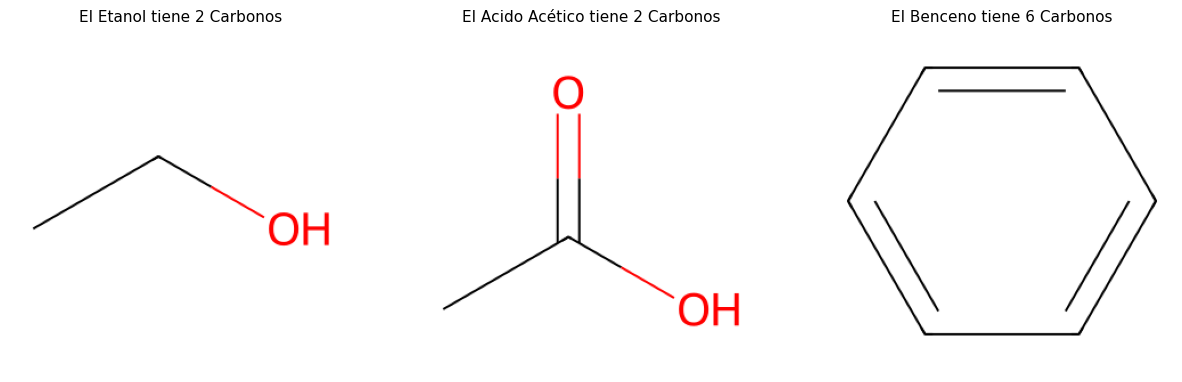

In [50]:
def calcular_num_carbonos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_carbonos = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'C'])
        return num_carbonos
    else:
        return None       
def plot_molecula(smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol)
    return img
    
# Moleculas Test
EtanolSmile = "CCO"             # Etanol
AcidoAceticoSmile = "CC(=O)O"  # Ácido acético
BencenoSmile = "C1=CC=CC=C1"  # Benceno
#Usar Función para moleculas
Etanol = calcular_num_carbonos(EtanolSmile)
AcidoAcetico = calcular_num_carbonos(AcidoAceticoSmile)
Benceno = calcular_num_carbonos(BencenoSmile)
#Imagenes de  moleculas
img_Etanol=plot_molecula(EtanolSmile)
img_AcidoAcetico=plot_molecula(AcidoAceticoSmile)
img_Benceno=plot_molecula(BencenoSmile)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Calcular enlaces dobles Etanol
axs[0].imshow(img_Etanol)
axs[0].set_title(f"El Etanol tiene {Etanol} Carbonos",fontsize=11)
axs[0].axis('off')
# Subplot 2 = Calcular enlaces dobles Acido Acético
axs[1].imshow(img_AcidoAcetico)
axs[1].axis('off')
axs[1].set_title(f"El Acido Acético tiene {AcidoAcetico} Carbonos",fontsize=11)
#Subplot 3 = Calcular enlaces dobles Benceno
axs[2].imshow(img_Benceno)
axs[2].axis('off')
axs[2].set_title(f"El Benceno tiene {Benceno} Carbonos",fontsize=11)
# Mostrar
plt.show()

#### Una vez verificamos la función la aplicamos a nuestro dataframe y agrupamos a nuestras moleculas bajo esta característica:

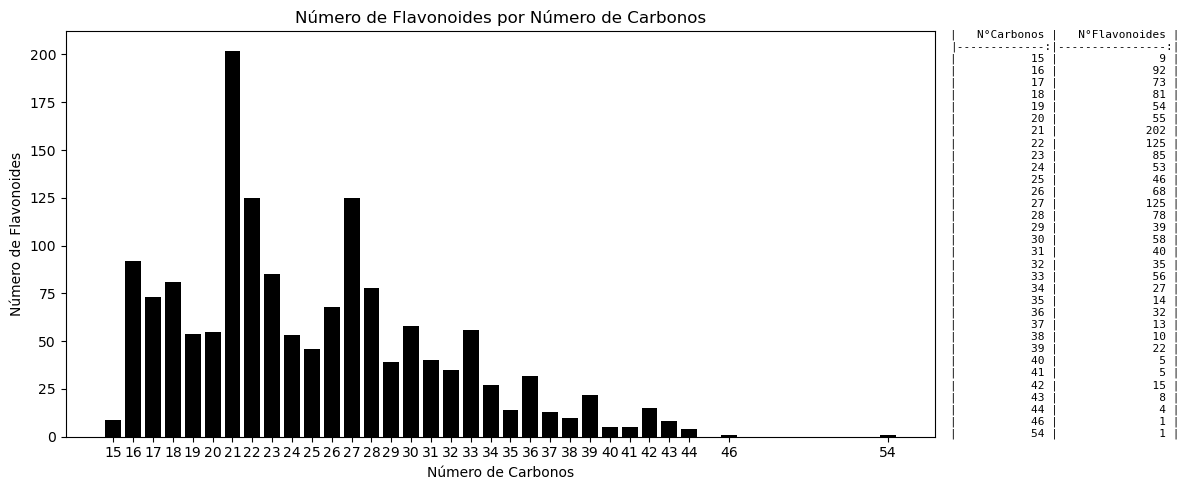

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID,N°Carbonos
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070,22
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849,26
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005,28
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054,33
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019,22


In [51]:
df['N°Carbonos'] = df['SMILES'].apply(calcular_num_carbonos)
# Group by Carbonos
grupos_por_carbonos = df.groupby('N°Carbonos').size()
# Df
df_resultado_carbonos = grupos_por_carbonos.reset_index()
df_resultado_carbonos.columns = ["N°Carbonos", "N°Flavonoides"]
# Markdown
df_resultado_md = df_resultado_carbonos.to_markdown(index=False)

# Plot
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[100, 1])  # Ancho relativo de los subplots
# Subplot 1 = Grafico Carbono
ax1 = fig.add_subplot(gs[0]) #Añadir subplot ax1 a primera cuadricula del plot
ax1.bar(df_resultado_carbonos['N°Carbonos'], df_resultado_carbonos['N°Flavonoides'], color='black', width=0.8) #Columnas del Df
ax1.set_xlabel('Número de Carbonos')
ax1.set_ylabel('Número de Flavonoides')
ax1.set_title('Número de Flavonoides por Número de Carbonos')
ax1.set_xticks(df_resultado_carbonos['N°Carbonos']) 
# Sub plot 2 = Markdown
ax2 = fig.add_subplot(gs[1])
ax2.text(0, 0.5, df_resultado_md, ha='left', va='center', fontsize=8, color='black', fontfamily='monospace')
ax2.axis('off')  # Desactivar ejes 
#Mostrar  
plt.tight_layout()
plt.show()
df.head()

#### Hacemos lo mismo con los Oxigenos:

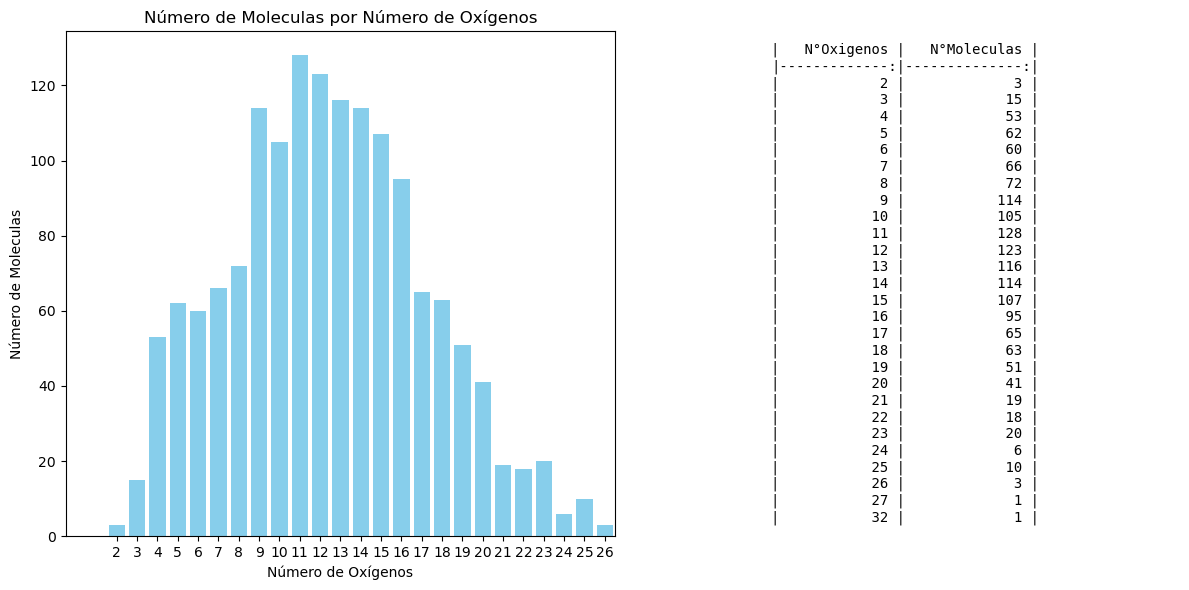

In [52]:
def calcular_num_oxigenos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_oxigenos = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'O'])
        return num_oxigenos
    else:
        return None
    
df['N°Oxigenos'] = df['SMILES'].apply(calcular_num_oxigenos)
# Group by Oxigenos
grupos_por_oxigenos = df.groupby('N°Oxigenos').size()
# Df
df_resultado_oxigeno = grupos_por_oxigenos.reset_index()
df_resultado_oxigeno.columns = ["N°Oxigenos", "N°Moleculas"]
# Markdown 
df_resultado_md = df_resultado_oxigeno.to_markdown(index=False)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Subplot 1 = Gráfico
ax1.bar(df_resultado_oxigeno['N°Oxigenos'], df_resultado_oxigeno['N°Moleculas'], color='skyblue')
ax1.set_xlabel('Número de Oxígenos')
ax1.set_ylabel('Número de Moleculas')
ax1.set_title('Número de Moleculas por Número de Oxígenos')
ax1.set_xticks(df_resultado_oxigeno['N°Oxigenos'])
ax1.grid(False)  # Desactivar las cuadrículas en el gráfico
ax1.set_xlim(-0.5, len(df_resultado_oxigeno) - 0.5)
# Subplot 2 = Markdown
ax2.axis('off')  # Desactivar ejes en el segundo subplot
ax2.text(0.5, 0.5, df_resultado_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')

#Mostrar 
plt.tight_layout()
plt.show()

#### Y ahora para buscar átomos menos probables:

In [53]:
def calcular_num_cobre(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_cobre = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'Cu'])
        return num_cobre
    else:
        return None      
df['N°Cu'] = df['SMILES'].apply(calcular_num_cobre)
# Group by Cu
grupos_por_cobre = df.groupby('N°Cu').size().reset_index()
grupos_por_cobre.columns = ["N°Cu", "N° Flavonoides"]
# Mostrar Group by
print("Resultados:")
print(grupos_por_cobre)
print("\n___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°Cu' 
print(df['N°Cu'].to_frame().sample(n=10))

Resultados:
   N°Cu  N° Flavonoides
0     0            1531

___________________________
Df
___________________________
      N°Cu
293      0
1502     0
729      0
1190     0
1037     0
508      0
215      0
620      0
18       0
772      0


In [54]:
def calcular_num_fierro(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_fierro = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'Fe'])
        return num_fierro
    else:
        return None
df['N°Fe'] = df['SMILES'].apply(calcular_num_fierro)
# Group by Fe
grupos_por_fierro = df.groupby('N°Fe').size().reset_index()
grupos_por_fierro.columns = ["N°Fe", "N°Flavonoides"]
# Mostrar Group by Fe
print("Resultados:")
print(grupos_por_fierro)
print("___________________________")
print("Df")
print("___________________________")
# Imprimir la columna 'N°Fe' 
print(df['N°Fe'].to_frame().sample(n=10))

Resultados:
   N°Fe  N°Flavonoides
0     0           1531
___________________________
Df
___________________________
      N°Fe
741      0
1006     0
1346     0
987      0
1470     0
1046     0
123      0
887      0
756      0
740      0


In [55]:
def calcular_num_S(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_S = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'S'])
        return num_S
    else:
        return None
df['N°S'] = df['SMILES'].apply(calcular_num_S)
# Group by Azufre
grupos_por_S = df.groupby('N°S').size().reset_index()
grupos_por_S.columns = ["N°S", "N°Flavonoides"]
# Mostrar Group By
print("Resultados:")
print(grupos_por_S)
print("___________________________")
print("Df")
print("___________________________")
# Mostrar la columna 'N°S' 
print(df['N°S'].to_frame().sample(n=10))

Resultados:
   N°S  N°Flavonoides
0    0           1459
1    1             66
2    2              6
___________________________
Df
___________________________
      N°S
1074    0
642     0
1077    0
20      0
1215    0
567     0
1102    0
49      0
1229    0
125     0


In [56]:
def calcular_num_N(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_N = len([atom.GetSymbol() for atom in mol.GetAtoms() if atom.GetSymbol() == 'N'])
        return num_N
    else:
        return None
df['N°N'] = df['SMILES'].apply(calcular_num_N)
# Group by N
grupos_por_N = df.groupby('N°N').size().reset_index()
grupos_por_N.columns = ["N°N", "N° Flavonoides"]
# Mostrar Group by
print("Resultados:")
print(grupos_por_N)
print("___________________________")
print("Df")
print("___________________________")
# Mostrar la columna 'N°N' 
print(df['N°N'].to_frame().sample(n=10))

Resultados:
   N°N  N° Flavonoides
0    0            1518
1    1              12
2    3               1
___________________________
Df
___________________________
      N°N
1094    0
653     0
1209    0
1353    0
1483    0
717     0
1428    0
1121    0
248     0
120     0


## Eliminar columnas innecesarias

In [57]:
df = df.drop("N°Fe", axis=1)
df = df.drop("N°Cu", axis=1)
df.head()

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID,N°Carbonos,N°Oxigenos,N°S,N°N
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070,22,14,0,0
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849,26,13,0,0
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005,28,17,0,0
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054,33,15,0,0
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019,22,11,0,0


## Conteo de anillos
_____________________________________________________________________________________________________________________
#### Los Flavonoides tienen anillos en su composición los cuales podemos contarlos y subclasificarlos de acuerdo a este criterio, esto es posible hacerlo mediante la función GetSymmSSSR: 
GetSymmSSSR es un método de la biblioteca RDKit que se utiliza para calcular los anillos simétricos más pequeños que rodean a los átomos de una molécula; SSSR significa "Smallest Set of Smallest Rings."
_____________________________________________________________________________________________________________________
#### Test contar anillos:

Número de anillos en Naftaleno (C1=CC=C2C=CC=CC2=C1): 2


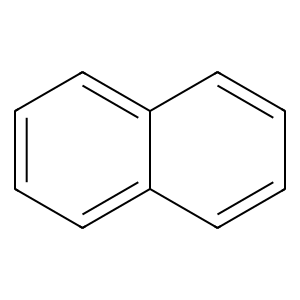

In [58]:
def mostrar_molecula (smile):
    mol = Chem.MolFromSmiles(smile)
    img = Draw.MolToImage(mol)
    display(img)   
    
def contar_anillos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        num_anillos = len(Chem.GetSymmSSSR(mol))  # Obtener el número de sistemas de anillos(SSSR)
        return num_anillos
    else:
        return "Error al procesar la molécula"     
# Test
naftaleno_smiles = "C1=CC=C2C=CC=CC2=C1"  # Naftaleno
# Aplicar función
num_anillos_naftaleno = contar_anillos(naftaleno_smiles)
print(f"Número de anillos en Naftaleno ({naftaleno_smiles}): {num_anillos_naftaleno}")
mostrar_molecula(naftaleno_smiles)

### Aplicar función al Df

In [59]:
df['N°Anillos'] = df['SMILES'].apply(contar_anillos)
df.head()

,ChEBI ID,ChEBI Name,SMILES,deltag,SID,CID,N°Carbonos,N°Oxigenos,N°S,N°N,N°Anillos
0,177972,"3,4,5-trihydroxy-6-{[5,6,7-trihydroxy-2-(4-hyd...",O1C(OC2=C(OC3=C(C2=O)C(O)=C(O)C(O)=C3)C4=CC(OC...,-9.4,85377015,131835070,22,14,0,0,4
1,191634,Neoliquiritin 2''-apioside,O(C1C(O)C(O)C(OC1OC2=CC=3OC(CC(=O)C3C=C2)C4=CC...,-9.9,85390422,131752849,26,13,0,0,5
2,186794,Haploside F,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC2=C(O)C=3OC(=C...,-10.3,85385648,44260005,28,17,0,0,5
3,197154,Sagittatoside A,O([C@@H]1[C@H](O)[C@@H](O)[C@@H](O[C@H]1OC2=C(...,-10.6,85395895,13916054,33,15,0,0,5
4,188752,Diosmetin 7-O-beta-D-glucopyranoside,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC=2...,-9.0,85387578,11016019,22,11,0,0,4


# Visualizar numero de anillos vs Flavonoides

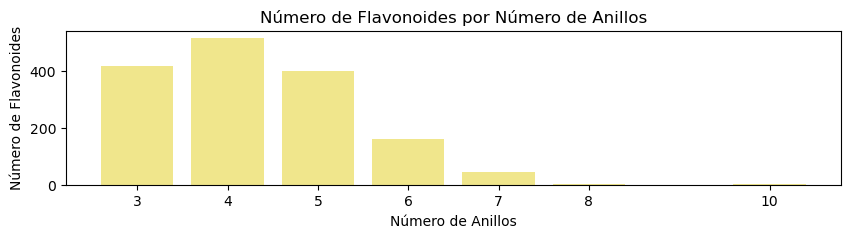

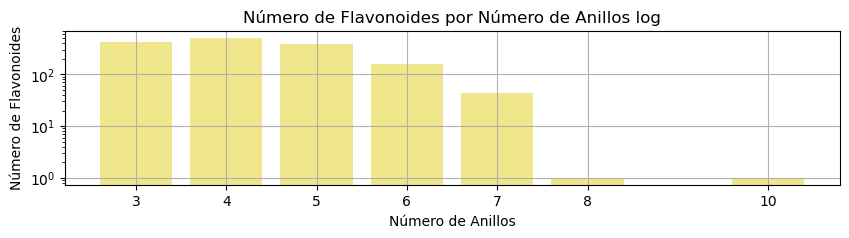

In [60]:
grupos_por_anillos = df.groupby('N°Anillos').size()
# Graficar Df Anillos
plt.figure(figsize=(10, 2))
plt.bar(grupos_por_anillos.index, grupos_por_anillos.values, color='khaki')
plt.xlabel('Número de Anillos')
plt.ylabel('Número de Flavonoides')
plt.title('Número de Flavonoides por Número de Anillos')
plt.xticks(grupos_por_anillos.index) #Generar etiqueta en eje X solo si hay resultados
plt.grid(False)
plt.show()
# Graficar en escala logaritmica
plt.figure(figsize=(10, 2))
plt.bar(grupos_por_anillos.index, grupos_por_anillos.values, color='khaki')
plt.xlabel('Número de Anillos')
plt.ylabel('Número de Flavonoides')
plt.title('Número de Flavonoides por Número de Anillos log')
plt.xticks(grupos_por_anillos.index)
plt.grid(True)
plt.yscale('log')
# Mostrar
plt.show()

# Conteo de anillos aromáticos
_____________________________________________________________________________________________________________

### RDkit nos permite crear formulas para detectar la aromaticidad de los anillos de nuestras moleculas
###### Fuente : https://sourceforge.net/p/rdkit/mailman/message/23801106/
___________________________________________________________________________________________________________________________________________________

### Test contar anillos aromáticos:

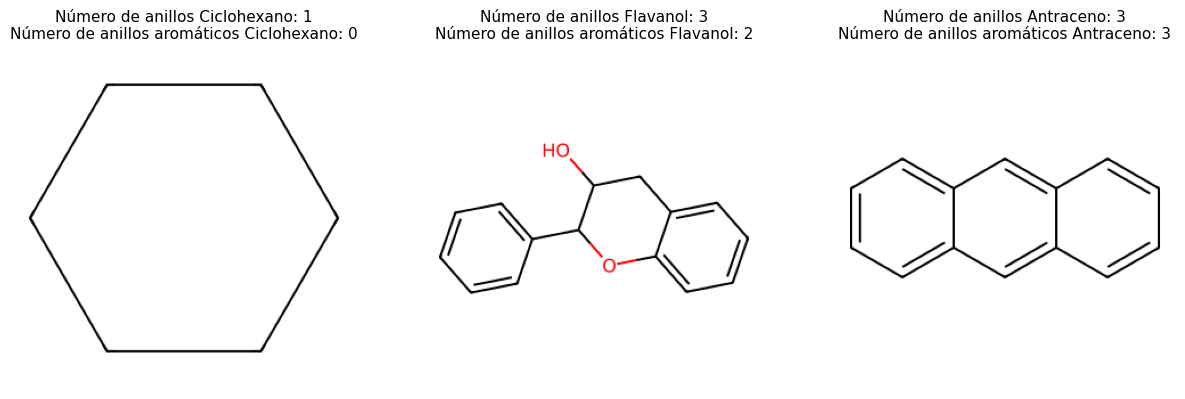

In [61]:
def contar_aromaticos(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return "Error al procesar la molécula"
    ring_info = mol.GetRingInfo()
    atom_rings = ring_info.AtomRings()
    bond_rings = ring_info.BondRings()
    anillos_aromaticos = 0
    for bond_ring in bond_rings:
        aromatico = True
        for bond_idx in bond_ring:
            if not mol.GetBondWithIdx(bond_idx).GetIsAromatic():
                aromatico = False
                break
        if aromatico:
            anillos_aromaticos += 1
    return anillos_aromaticos
    
#Moleculas Test Anillo Aromático
#----------------------------------------Ciclohexano
Ciclohexanosmile = 'C1CCCCC1'  
imagenciclohexano = plot_molecula(Ciclohexanosmile)
anillos_ciclohexano = contar_anillos(Ciclohexanosmile)
aromaticos_ciclohexano = contar_aromaticos(Ciclohexanosmile)
#----------------------------------------Flavonol
Flavonolsmile = "C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O"
imagenflavonol = plot_molecula(Flavonolsmile)
anillos_flavonol = contar_anillos(Flavonolsmile)
aromaticos_flavonol = contar_aromaticos(Flavonolsmile)
#----------------------------------------Antraceno
Antracenosmile = "C1=CC2=CC3=CC=CC=C3C=C2C=C1"
imagenantraceno = plot_molecula(Antracenosmile)
anillos_antraceno = contar_anillos(Antracenosmile)
aromaticos_antraceno = contar_aromaticos(Antracenosmile)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Subplot 1 = Calcular enlaces dobles Flavanona
axs[0].imshow(imagenciclohexano)
axs[0].set_title(f"Número de anillos Ciclohexano: {anillos_ciclohexano}\nNúmero de anillos aromáticos Ciclohexano: {aromaticos_ciclohexano}", fontsize=11)
axs[0].axis('off')
# Subplot 2 = Calcular enlaces dobles Flavanol
axs[1].imshow(imagenflavonol)
axs[1].axis('off')
axs[1].set_title(f"Número de anillos Flavanol: {anillos_flavonol}\nNúmero de anillos aromáticos Flavanol: {aromaticos_flavonol}",fontsize=11)
#Subplot 3 = Calcular enlaces dobles Nitrisona
axs[2].imshow(imagenantraceno)
axs[2].axis('off')
axs[2].set_title(f"Número de anillos Antraceno: {anillos_antraceno}\nNúmero de anillos aromáticos Antraceno: {aromaticos_antraceno}",fontsize=11)
#Mostrar Plot
plt.show()

### Aplicar función al Df

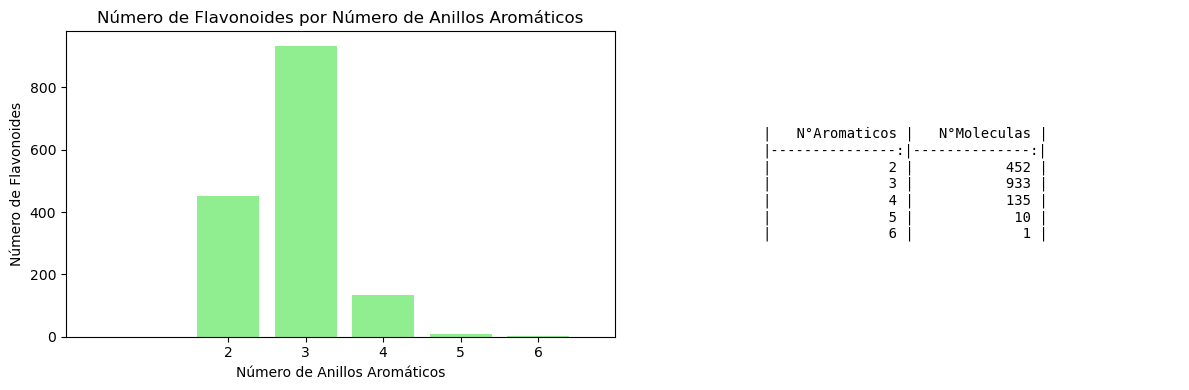

In [62]:
df['N°Aromaticos'] = df['SMILES'].apply(contar_aromaticos)
# Group by anillos aromáticos
grupos_por_aromaticos = df.groupby('N°Aromaticos').size()
# Df
df_resultado_aromatico = grupos_por_aromaticos.reset_index()
df_resultado_aromatico.columns = ["N°Aromaticos", "N°Moleculas"]
# Markdown
df_resultado_md = df_resultado_aromatico.to_markdown(index=False)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
# Subplot 1 = N° Anillos Aromáticos en el Df
ax1.bar(df_resultado_aromatico['N°Aromaticos'], df_resultado_aromatico['N°Moleculas'], color='lightgreen')
ax1.set_xlabel('Número de Anillos Aromáticos')
ax1.set_ylabel('Número de Flavonoides')
ax1.set_title('Número de Flavonoides por Número de Anillos Aromáticos')
ax1.set_xticks(df_resultado_aromatico['N°Aromaticos'])
ax1.grid(False)  # Desactivar las cuadrículas en el gráfico
ax1.set_xlim(-0.1, len(df_resultado_aromatico) + 2)
# Subplot 2 = Markdown
ax2.axis('off')  # Desactivar ejes en el segundo subplot
ax2.text(0.5, 0.5, df_resultado_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
#Mostrar
plt.tight_layout()
plt.show()

# Clasificación por subestructuras
____________________________________________________________________________________________________________________________________
Gracias a RDkit podemos clasificar nuestro dataframe segun las estructuras primarias de los flavonoides
Álvarez Castro, E., & Orallo Cambeiro, F. (2003). Actividad biológica de los flavonoides (I). Acción frente al cáncer. Offarm, 22(10), 130–140. https://www.elsevier.es/es-revista-offarm-4-articulo-actividad-biologica-flavonoides-i-accion-13054406


### Isoflavonas:
________________________________________________________________________________________________________________________________________________________

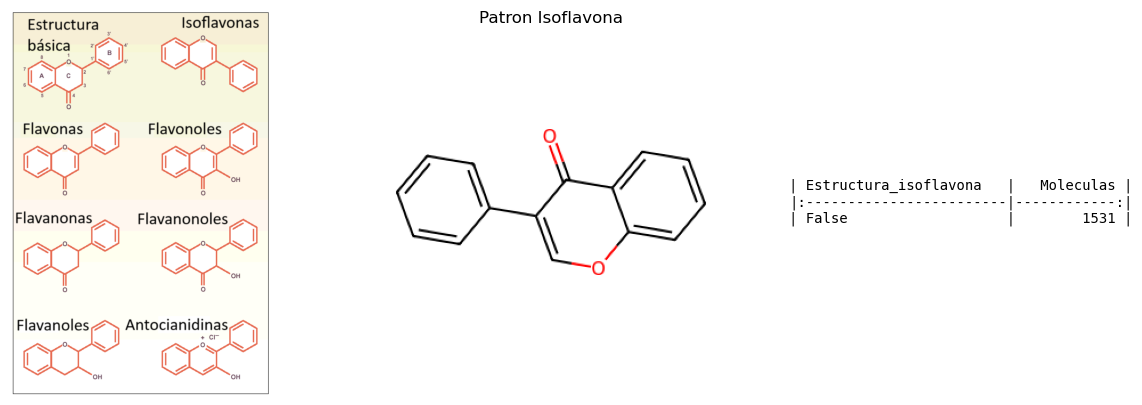

In [63]:
from PIL import Image
def verificar_isoflavona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_isoflavona)
    else:
        return False  # Si la molécula no se puede convertir, asumimos que no contiene la isoflavona
#Patron Isoflavona
smiles_isoflavona = "C1=CC=C(C=C1)C2=COC3=CC=CC=C3C2=O"
imagen_isoflavona = plot_molecula(smiles_isoflavona)
patron_isoflavona = Chem.MolFromSmiles(smiles_isoflavona)

# Aplicar función a Df
df['Estructura_isoflavona'] = df['SMILES'].apply(verificar_isoflavona)
# Group by Estructura_isoflavona
grupo_isoflavona = df.groupby('Estructura_isoflavona').size()
#Markdwon
grupo_isoflavona_md = grupo_isoflavona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown(index=False)
ruta_imagen = "imgs/flavsimg.png"
imagen = Image.open(ruta_imagen)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 
# Subplot 1 = Mostrar la imagen de referencia de estructuras Flavonoides
axs[0].imshow(imagen)
axs[0].axis('off')
# Subplot 2 = Isoflavona
axs[1].imshow(imagen_isoflavona)
axs[1].set_title("Patron Isoflavona")
axs[1].axis('off')
#Subplot 3 = Mostrar Markdown
axs[2].axis('off')
axs[2].text(0.5, 0.5, grupo_isoflavona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
#Mostrar Plot
plt.show()

### Test detectar estructura Isoflavona:
________________________________________________________________________________________________________________________________________________________
###### Ya que no se detectaron Isoflavonas en el  Df vamos a testear nuestra función con distintas moleculas:
###### (Apretar botón actualizar para probar distintas moleculas)

In [64]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import random

# Lista de moléculas TEST
moleculas = [
    "C1CC2=C(C1)C(=O)C3=C(C2=O)C=C(C=C3)O",
    "C1=CC=C(C=C1)C2=COC3=C2C=CC(=C3)O",
    "COC1=CC=C(C=C1)C2=COC3=C(C2=O)C=CC(=C3)O",
    "OC1=CC=C(C=C1)C1=COC2=CC(O)=CC(O)=C2C1=O",
    "C1=CC=CC=C1",
     "C1=CC=C2C=CC=CC2=C1",
    "COC1=C(C=C2C(=C1)C(=O)C(=CO2)C3=CC=C(C=C3)O)O"
]

# Crear Widget
output = widgets.Output()

# Función para actualizar el gráfico
def actualizar_grafico(b):
    with output:
        clear_output(wait=True)
        # Seleccionar una molécula aleatoria de la lista y verificar si es una Isoflavona
        smiles_molecula_aleatoria = random.choice(moleculas)
        imagen_test_isoflavona = plot_molecula(smiles_molecula_aleatoria)
        es_isoflavona = verificar_isoflavona(smiles_molecula_aleatoria)

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  # Ajustar el tamaño de la figura
        # Subplot 1: Isoflavona
        axs[0].imshow(imagen_isoflavona)
        axs[0].set_title("Isoflavona")
        axs[0].set_axis_off()
        # Subplot 2: Test
        axs[1].imshow(imagen_test_isoflavona)
        axs[1].set_title(f"La molécula es Isoflavona: {es_isoflavona}")
        axs[1].set_axis_off()
        # Mostrar el gráfico
        plt.tight_layout()
        display(fig)
        plt.close(fig)

# Botón
boton_actualizar = widgets.Button(
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')  # Ajustar el ancho del botón al 50% del contenedor
)

boton_actualizar.on_click(actualizar_grafico)

# Mostrar
display(boton_actualizar)
display(output)
actualizar_grafico(None)

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

### Isoflavanonas
____________________________________________________________________________________________________

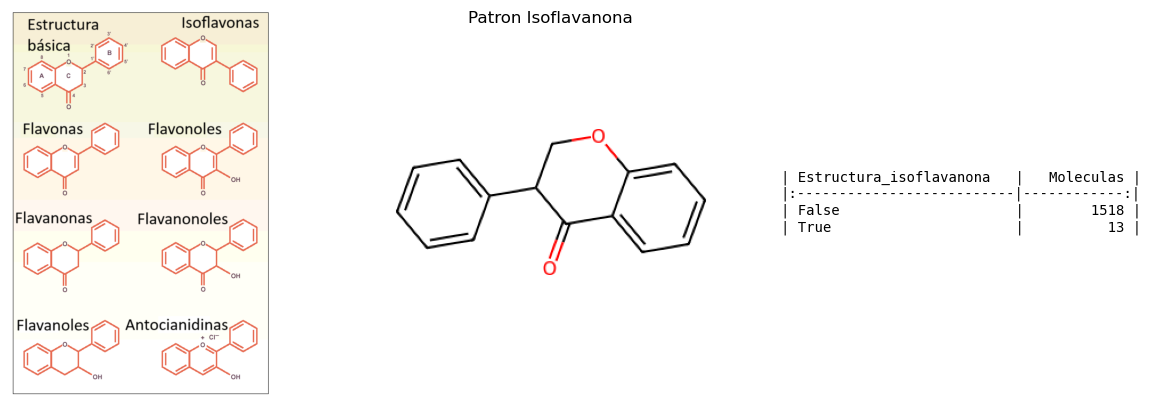

In [65]:
def verificar_isoflavanona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_isoflavanona)
    else:
        return False  # Si la molécula no se puede convertir, asumimos que no contiene el isoflavanona
        
#Patron Isoflavonas
smiles_isoflavanona = "C1C(C(=O)C2=CC=CC=C2O1)C3=CC=CC=C3"
imagen_isoflavanona = plot_molecula(smiles_isoflavanona)
patron_isoflavanona = Chem.MolFromSmiles(smiles_isoflavanona)

# Aplicar la función a Df 
df['Estructura_isoflavanona'] = df['SMILES'].apply(verificar_isoflavanona)
# Group by Estructura_isoflavanona
grupo_isoflavanona = df.groupby('Estructura_isoflavanona').size()
grupo_isoflavanona_md = grupo_isoflavanona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown(index = False)

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
# Subplot 1 = Mostrar la imagen de referencia de estructuras Flavonoides
ruta_imagen = "imgs/flavsimg.png"
imagen = Image.open(ruta_imagen)
axs[0].imshow(imagen)
axs[0].axis('off')
# Subplot 2 = Isoflavanona
axs[1].imshow(imagen_isoflavanona)
axs[1].set_title("Patron Isoflavanona")
axs[1].axis('off')
#Subplot 3 = Mostrar Markdown
axs[2].axis('off')
axs[2].text(0.5, 0.5, grupo_isoflavanona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

#### Si Estructura_isoflavanona = True nombramos como isoflavanona nuestras moleculas

In [66]:
df['Tipo_flavonoide'] = ''
# Mantener mismo valor en columna si no se cumple condicion 
valor_actual = df['Tipo_flavonoide']
# Conseguir índices de Isoflavanonas
indices_isoflavanona = df[df['Estructura_isoflavanona'] == True].index.tolist()
# Definir condiciones
condiciones = [
    (df['Estructura_isoflavanona'] == True)
]
# Definir valores
valores = ['Isoflavanona']
# Asignar valores a la columna 'Tipo_flavonoide' según las condiciones sin modificar los valores actuales
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)
# Mostrar Isoflavanona clasificada
df.loc[indices_isoflavanona, ['SMILES', 'ChEBI Name', 'Estructura_isoflavanona', 'Tipo_flavonoide']].sample(n=10)

,SMILES,ChEBI Name,Estructura_isoflavanona,Tipo_flavonoide
363,O1CC(C2=C(OC)C=C(OC)C=C2)C(=O)C3=C1C=C(O)C=C3,Sativanone,True,Isoflavanona
1322,C=1(C=C(C2=C(C1)OCC(C2=O)C=3C(=C(C(=CC3)O)OC)O...,parvisoflavanone,True,Isoflavanona
897,O1CC(C2=C(OC)C=C(O)C=C2)C(=O)C=3C1=CC(O)=CC3O,Isoferreirin,True,Isoflavanona
1033,O1CC(C=2C(OC)=CC=3OCOC3C2)C(=O)C=4C1=CC(O)=CC4O,Cicerin,True,Isoflavanona
10,O1CC(C(=O)C2=C1C(=C(OC)C=C2O)C)C3=CC(OC)=CC=C3,5-hydroxy-7-methoxy-3-(3-methoxyphenyl)-8-meth...,True,Isoflavanona
301,O1CC(C2=C(OC)C=C(O)C=C2)C(=O)C3=C1C=C(O)C=C3OC,"4',7-Dihydroxy-2',5-dimethoxyisoflavanone",True,Isoflavanona
662,O1CC(C(=O)C2=C1C=C3OC=CC3=C2)C4=C(OC)C=C(OC)C=C4,Neoraunone,True,Isoflavanona
1069,O1CC(C(=O)C=2C1=CC(O)=C(OC)C2)C3=CC=C(O)C=C3,Dihydroglycitein,True,Isoflavanona
1258,O1CC(C2=CC(C(C)(C)C=C)=C(O)C=C2OC)C(=O)C=3C1=C...,Echinoisosophoranone,True,Isoflavanona
538,O1CC(C(=O)C=2C1=C(C(O)=CC2O)C)C3=CC=C(OC)C=C3,"5,7-Dihydroxy-4'-methoxy-8-methylisoflavanone",True,Isoflavanona


### Test clasificación Isoflavanona:
____________________________________________________________________________________________________
##### Vemos si nuestras moleculas clasificadas como Isoflavanonas cumplen con la clasificación

In [67]:
output = widgets.Output()
def actualizar_test_isoflavanona(b):
    with output:
        clear_output(wait=True)
        # Seleccionar una Isoflavanona aleatoria
        test_isoflavanona = random.choice(indices_isoflavanona)
        # Verificar Moleculas
        print(df.loc[test_isoflavanona, ['SMILES', 'ChEBI Name', 'Estructura_isoflavanona']])
        smiles_isoflavanonas = df.loc[test_isoflavanona, 'SMILES']
        imagen_test_isoflavanona = plot_molecula(smiles_isoflavanonas)
        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        # Subplot 1: Isoflavona
        axs[0].imshow(imagen_isoflavanona)
        axs[0].set_title("Isoflavanona")
        axs[0].set_axis_off()
        # Subplot 2: Test
        axs[1].imshow(imagen_test_isoflavanona)
        axs[1].set_title("Test Isoflavanona")
        axs[1].set_axis_off()
        # Mostrar el gráfico
        plt.tight_layout()
        display(fig)
        plt.close(fig)

# Botón
boton_actualizar = widgets.Button(
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_isoflavanona)

# Mostrar
display(boton_actualizar)
display(output)
actualizar_test_isoflavanona(None)

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

### Flavonas y Flavonoles
____________________________________________________________________________________________________
#### Flavonas y Flavonoles comparten el mismo esqueleto, por lo que teoricamente debemos encontrar mas Flavonas que Flavonoles 

### Flavonas
____________________________________________________________________________________________________

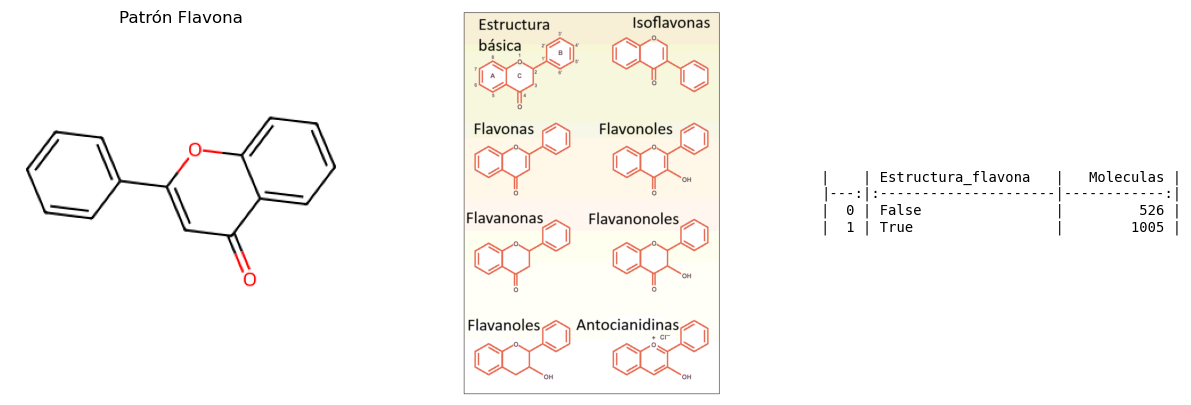

In [68]:
def verificar_flavona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavona)
    else:
        return False  
#Patron Flavona
smiles_flavona = "C1=CC=C(C=C1)C2=CC(=O)C3=CC=CC=C3O2"
imagen_flavona = plot_molecula(smiles_flavona)
patron_flavona = Chem.MolFromSmiles(smiles_flavona)
# Aplicar la función al Df
df['Estructura_flavona'] = df['SMILES'].apply(verificar_flavona)
# Group by Estructra_flavona
grupo_flavona = df.groupby('Estructura_flavona').size()
# Markdwon
grupo_flavona_md = grupo_flavona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
for ax in axs:
    ax.axis('off')
#Subplot 1 = "Flavona"
axs[0].set_title("Patrón Flavona")  
axs[0].imshow(imagen_flavona)
#Subplot 2 = "Estructura flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = Markdown
axs[2].text(0.5, 0.5, grupo_flavona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

### Flavonoles
____________________________________________________________________________________________________

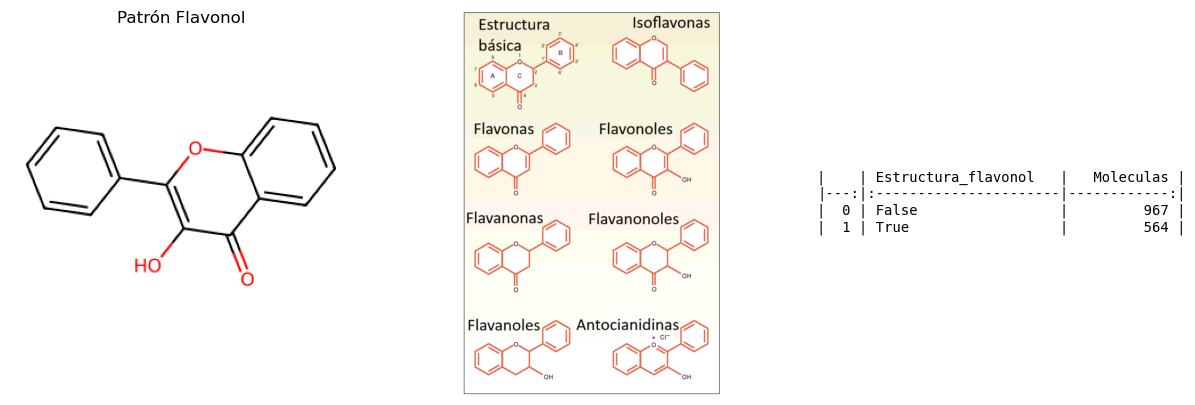

In [69]:
def verificar_flavonol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavonol)
    else:
        return False  
# Patron Flavonol
smiles_flavonol =("C1=CC=C(C=C1)C2=C(C(=O)C3=CC=CC=C3O2)O")
imagen_flavonol = plot_molecula(smiles_flavonol)
patron_flavonol = Chem.MolFromSmiles(smiles_flavonol)
# Aplicar la función al Df
df['Estructura_flavonol'] = df['SMILES'].apply(verificar_flavonol)
# Group by Estructura_flavonol
grupo_flavonol = df.groupby('Estructura_flavonol').size()
# Markdown 
grupo_flavonol_md = grupo_flavonol.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
for ax in axs:
    ax.axis('off')
#Subplot 1 = "Flavonol
axs[0].set_title("Patrón Flavonol")  # Título para la imagen 
axs[0].imshow(imagen_flavonol)
# Subplot 2 = "Estructura flavonoides
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = Markdown
axs[2].text(0.5, 0.5, grupo_flavonol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar el gráfico
plt.show()

##### De esta manera si Estructura_flavona = True & Estructura_flavonol = False entonces la molecula es Flavona
##### Por el contrario si Estructura_flavona = True & Estructura_flavonol = True entonces la molecula es Flavonol
## Muestra Df
____________________________________________________________________________________________________
###### ("Actualizar" para generar nueva muestra del df)

In [26]:
valor_actual = df['Tipo_flavonoide']
#Condiciones
condiciones = [
    (df['Estructura_flavona'] == True) & (df['Estructura_flavonol'] == False),
    (df['Estructura_flavona'] == True) & (df['Estructura_flavonol'] == True)
]
# Valores 
valores = ['Flavona', 'Flavonol']
# Asignar valores a la columna 'Tipo_flavonoide'
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)

# Crear Widget
output = widgets.Output()
# Función para actualizar el Test
def actualizar_muestra_df(b):
    with output:
        clear_output(wait=True)
        # Mostrar una muestra del DataFrame
        display(df[['Estructura_flavona', 'Estructura_flavonol', 'Tipo_flavonoide']].sample(n=10))

# Botón
boton_actualizar = widgets.Button(
    description="Actualizar",
    layout=widgets.Layout(width='37.5%')
)
boton_actualizar.on_click(actualizar_muestra_df)

# Mostrar
display(boton_actualizar)
display(output)
actualizar_muestra_df(None)

Button(description='Actualizar', layout=Layout(width='37.5%'), style=ButtonStyle())

Output()

### Test Flavonas clasificadas:
____________________________________________________________________________________________________

In [27]:
output = widgets.Output()
def actualizar_test_flavona(b):
    with output:
        clear_output(wait=True)
        indices_flavona = df[df['Tipo_flavonoide'] == 'Flavona'].index.tolist()
        #Flavona Aleatoria
        test_flavona = random.choice(indices_flavona)
        smiles_molecula_flavona = df.loc[test_flavona, 'SMILES']
        imagen_flavona_test = plot_molecula(smiles_molecula_flavona)
        # Info Molecula
        print(df.loc[test_flavona, ['SMILES', 'ChEBI Name', 'Estructura_flavona']])

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        # Subplot 1: Isoflavona
        axs[0].imshow(imagen_flavona)
        axs[0].set_title("Flavona")
        axs[0].set_axis_off()
        # Subplot 2: Test
        axs[1].imshow(imagen_flavona_test)
        axs[1].set_title("Test Flavona")
        axs[1].set_axis_off()
        # Mostrar el gráfico
        plt.tight_layout()
        display(fig)
        plt.close(fig)

# Botón
boton_actualizar = widgets.Button(
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_flavona)

# Mostrar
display(boton_actualizar)
display(output)
actualizar_test_flavona(None)

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

### Test Flavonoles clasificados:
____________________________________________________________________________________________________


In [28]:
output = widgets.Output()
def actualizar_test_flavonol(b):
    with output:
        clear_output(wait=True)
        indices_flavonol = df[df['Tipo_flavonoide'] == 'Flavonol'].index.tolist()
        #Flavonol Aleatorio
        test_flavonol = random.choice(indices_flavonol)
        smiles_molecula_flavonol = df.loc[test_flavonol, 'SMILES']
        imagen_flavonol_test = plot_molecula(smiles_molecula_flavonol)
        # Info Molecula
        print(df.loc[test_flavonol, ['SMILES', 'ChEBI Name', 'Estructura_flavonol']])

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        # Subplot 1: Isoflavona
        axs[0].imshow(imagen_flavonol)
        axs[0].set_title("Flavonol")
        axs[0].set_axis_off()
        # Subplot 2: Test
        axs[1].imshow(imagen_flavonol_test)
        axs[1].set_title("Test Flavonol")
        axs[1].set_axis_off()
        # Mostrar el gráfico
        plt.tight_layout()
        display(fig)
        plt.close(fig)

# Botón
boton_actualizar = widgets.Button(
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_flavonol)

# Mostrar
display(boton_actualizar)
display(output)
actualizar_test_flavonol(None)

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

### Flavanonas y Flavanonoles:
____________________________________________________________________________________________________
##### Al igual que las Flavonas y Flavonoles, las  Flavanonas y Flavanonoles tambien comparten el mismo esqueleto, por lo que teoricamente debemos encontrar mas Flavanonas que Flavanonoles 

### Flavanonas
____________________________________________________________________________________________________

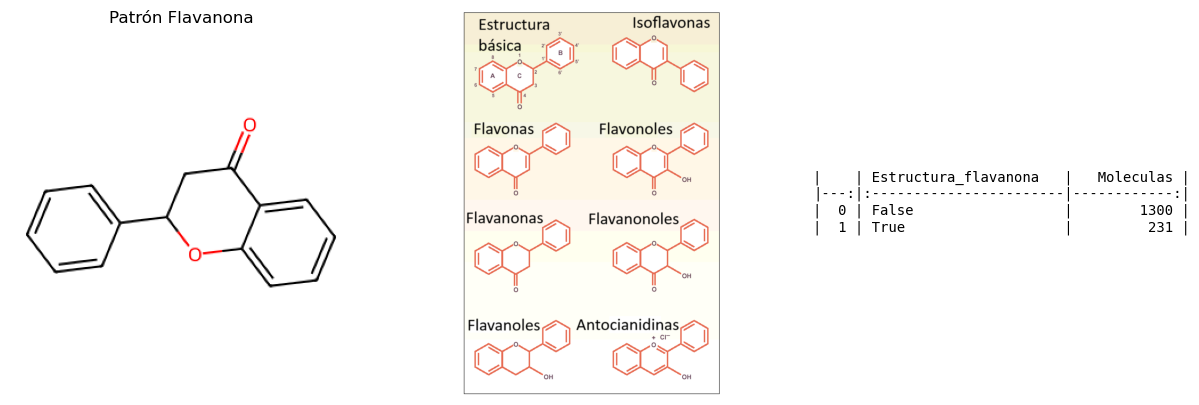

In [29]:
def verificar_flavanona(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanona)
    else:
        return False  
# Patron Flavanona
smiles_flavanona =("C1C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3")
imagen_flavanona = plot_molecula(smiles_flavanona)
patron_flavanona = Chem.MolFromSmiles(smiles_flavanona)
# Aplicar la función al Df
df['Estructura_flavanona'] = df['SMILES'].apply(verificar_flavanona)
# Group by Estructura_flavanona
grupo_flavanona = df.groupby('Estructura_flavanona').size()
# Markdown
grupo_flavanona_md = grupo_flavanona.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
for ax in axs:
    ax.axis('off')
# Subplot 1 = "Flavanona"
axs[0].set_title("Patrón Flavanona")  
axs[0].imshow(imagen_flavanona)
# Subplot 2 = "Estructura Flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = "Markdown"
axs[2].text(0.5, 0.5, grupo_flavanona_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar 
plt.show()

### Flavanonol
____________________________________________________________________________________________________

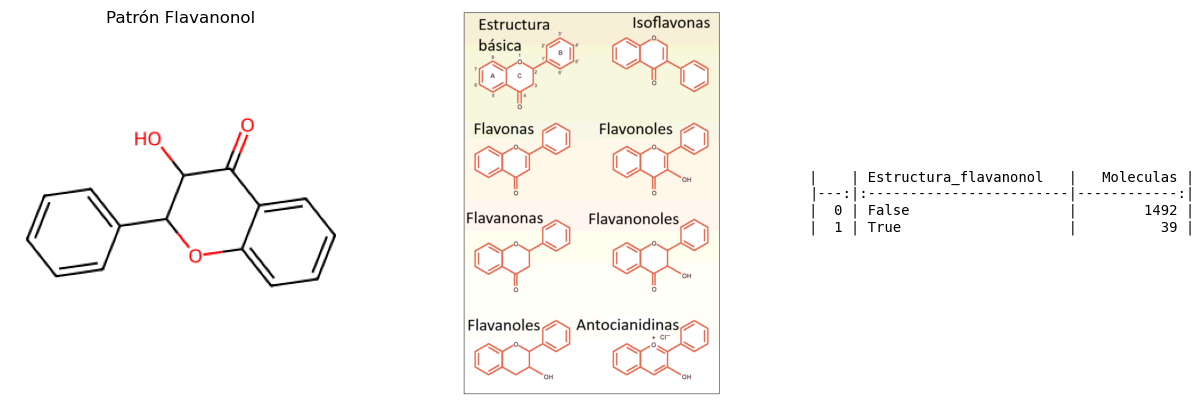

In [30]:
def verificar_flavanonol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanonol)
    else:
        return False  
# Patron Flavanonol
smiles_flavanonol =("C1(O)C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3")
patron_flavanonol = Chem.MolFromSmiles(smiles_flavanonol)
imagen_flavanonol = plot_molecula(smiles_flavanonol)
# Aplicar la función al Df
df['Estructura_flavanonol'] = df['SMILES'].apply(verificar_flavanonol)
# Group by Estructura_flavanonol
grupo_flavanonol = df.groupby('Estructura_flavanonol').size()
# Markdown
grupo_flavanonol_md = grupo_flavanonol.reset_index().rename(columns={0: 'Moleculas'}).to_markdown()

# Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  
for ax in axs:
    ax.axis('off')
# Subplot 1 = "Flavanonol"
axs[0].set_title("Patrón Flavanonol")  
axs[0].imshow(imagen_flavanonol)
# Subplot 2 = "Estructura Flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 = "Markdown"
axs[2].text(0.5, 0.5, grupo_flavanonol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
# Mostrar
plt.show()

##### Si Estructura_flavanona = True & Estructura_flavanonol = False entonces la molecula es Flavanona
##### Por el contrario si Estructura_flavanona = True & Estructura_flavanonol = True entonces la molecula es Flavanonol
## Muestra Df
____________________________________________________________________________________________________
###### ("Actualizar" para generar nueva muestra del df)

In [31]:
valor_actual = df['Tipo_flavonoide']
#Condiciones
condiciones = [
    (df['Estructura_flavanona'] == True) & (df['Estructura_flavanonol'] == False),
    (df['Estructura_flavanona'] == True) & (df['Estructura_flavanonol'] == True)
]
# Valores 
valores = ['Flavanona', 'Flavanonol']
# Asignar valores a la columna 'Tipo_flavonoide'
df['Tipo_flavonoide'] = np.select(condiciones, valores, default=valor_actual)

# Widget 
output = widgets.Output()
# Función para actualizar el Test
def actualizar_muestra_df_2(b):
    with output:
        clear_output(wait=True)
        # Mostrar una muestra del DataFrame
        display(df[['Estructura_flavanona', 'Estructura_flavanonol', 'Tipo_flavonoide']].sample(n=10))
# Botón
boton_actualizar = widgets.Button(
    description="Actualizar",
    layout=widgets.Layout(width='37.5%')
)
boton_actualizar.on_click(actualizar_muestra_df_2)
# Mostrar
display(boton_actualizar)
display(output)
actualizar_muestra_df_2(None)

Button(description='Actualizar', layout=Layout(width='37.5%'), style=ButtonStyle())

Output()

### Test clasificacion Flavanona:
____________________________________________________________________________________________________

In [32]:
output = widgets.Output()
def actualizar_test_flavanona(b):
    with output:
        clear_output(wait=True)
        #Índices Flavanona
        indices_flavanona = df[df['Tipo_flavonoide'] == 'Flavanona'].index.tolist()
        #Test Flavanona
        test_flavanona = random.choice(indices_flavanona) 
        smiles_molecula_flavanona = df.loc[test_flavanona, 'SMILES']
        imagen_flavanona_test = plot_molecula(smiles_molecula_flavanona)
        # Info Molecula
        print(df.loc[test_flavanona, ['SMILES', 'ChEBI Name', 'Estructura_flavanona']])

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        # Subplot 1: Isoflavona
        axs[0].imshow(imagen_flavanona)
        axs[0].set_title("Flavanona")
        axs[0].set_axis_off()
        # Subplot 2: Test
        axs[1].imshow(imagen_flavanona_test)
        axs[1].set_title("Test Flavanona")
        axs[1].set_axis_off()
        # Mostrar el gráfico
        plt.tight_layout()
        display(fig)
        plt.close(fig)

# Botón
boton_actualizar = widgets.Button(
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_flavanona)

# Mostrar
display(boton_actualizar)
display(output)
actualizar_test_flavanona(None)

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

### Test clasificacion Flavanonol
____________________________________________________________________________________________________

SMILES                   C=1C(=CC(=C2C1OC(C(C2=O)O)C3=CC(=C(C=C3)O)OC4C...
ChEBI Name                                        quercetin-3'-glucuronide
Estructura_flavanonol                                                 True
Name: 512, dtype: object


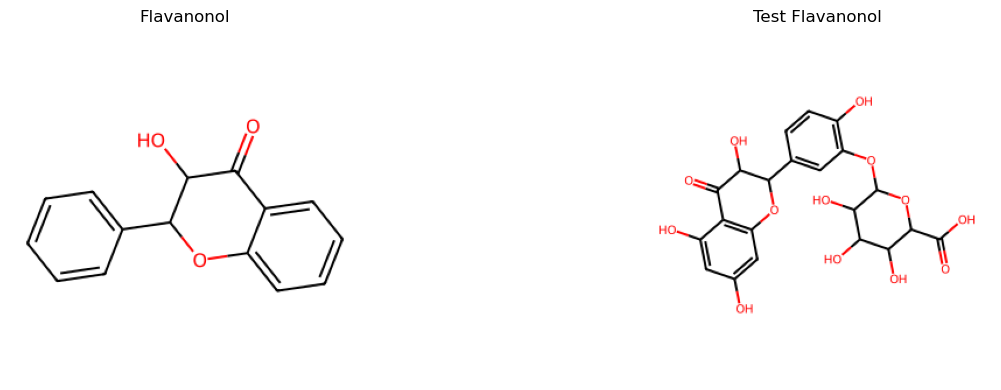

In [33]:
indices_flavanonol = df[df['Tipo_flavonoide'] == 'Flavanonol'].index.tolist()
#Flavanonol Aleatorio
test_flavanonol = random.choice(indices_flavanonol)
#Obtener imagen 
smiles_molecula_flavanonol = df.loc[test_flavanonol, 'SMILES']
imagen_flavanonol_test = plot_molecula(smiles_molecula_flavanonol)
# Info Molecula
print(df.loc[test_flavanonol, ['SMILES', 'ChEBI Name', 'Estructura_flavanonol']])

# Plot
fig, axs = plt.subplots(1, 2, figsize=(15, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Flavanonol
axs[0].imshow(imagen_flavanonol)
axs[0].set_title("Flavanonol")
axs[0].set_axis_off()
# Subplot 2 = Test
axs[1].imshow(imagen_flavanonol_test)
axs[1].set_title("Test Flavanonol")
axs[1].set_axis_off()
#Mostrar Plot
plt.tight_layout()
plt.show()

In [34]:
output = widgets.Output()
def actualizar_test_flavanonol(b):
    with output:
        clear_output(wait=True)
        #Índices Flavanonol
        indices_flavanonol = df[df['Tipo_flavonoide'] == 'Flavanonol'].index.tolist()
        #Test Flavanonol
        test_flavanonol = random.choice(indices_flavanonol) 
        smiles_molecula_flavanonol = df.loc[test_flavanonol, 'SMILES']
        imagen_flavanonol_test = plot_molecula(smiles_molecula_flavanonol)
        # Info Molecula
        print(df.loc[test_flavanonol, ['SMILES', 'ChEBI Name', 'Estructura_flavanonol']])

        # Plot
        fig, axs = plt.subplots(1, 2, figsize=(15, 3))  
        # Subplot 1: Isoflavona
        axs[0].imshow(imagen_flavanonol)
        axs[0].set_title("Flavanonol")
        axs[0].set_axis_off()
        # Subplot 2: Test
        axs[1].imshow(imagen_flavanonol_test)
        axs[1].set_title("Test Flavanonol")
        axs[1].set_axis_off()
        # Mostrar el gráfico
        plt.tight_layout()
        display(fig)
        plt.close(fig)

# Botón
boton_actualizar = widgets.Button(
    description="Actualizar",
    layout=widgets.Layout(width='78.75%')
)
boton_actualizar.on_click(actualizar_test_flavanonol)
# Mostrar
display(boton_actualizar)
display(output)
actualizar_test_flavanonol(None)

Button(description='Actualizar', layout=Layout(width='78.75%'), style=ButtonStyle())

Output()

#### Revisamos una muestra de nuestro dataframe y contamos las moleculas que nos quedan sin clasificar:

In [35]:
df[['ChEBI Name', 'SMILES', 'Tipo_flavonoide']].sample(n=10)

,ChEBI Name,SMILES,Tipo_flavonoide
20,Apigenin 7-glucuronosyl-(1->2)-glucuronide,O(C1[C@@H](O)[C@H](O)C(O[C@H]1OC=2C=C3OC(=CC(=...,Flavona
1045,Hispidulin 7-sulfate,S(OC=1C=C2OC(=CC(=O)C2=C(O)C1OC)C3=CC=C(O)C=C3...,Flavona
628,Hexandraside C,O(C1C(O)C(O)C(OC1OC2=C(C=3OC(=C(OC4OC(C(O)C(O)...,Flavonol
638,Sachaliside 2,O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC2=C(C(O)=C3C...,
285,Isorhamnetin 7-alpha-D-Glucosamine,O1C([C@@H](O)[C@H](O)C(N)[C@H]1OC=2C=C3OC(=C(O...,Flavonol
1010,"(2S)-7-[[(2R,3R,4S,5S,6R)-4,5-dihydroxy-6-(hyd...",C[C@H]1[C@@H]([C@H]([C@H]([C@@H](O1)O[C@@H]2[C...,Flavanona
675,Azaleatin 3-glucoside,O1[C@@H]([C@@H](O)C(O)C(O)[C@@H]1OC2=C(OC3=C(C...,Flavonol
602,Xanthorhamnin,O([C@H]1[C@@H](O)[C@@H](O[C@H]([C@@H]1O)C)OC[C...,Flavonol
702,5-hydroxy-2-(4-methoxyphenyl)-8-(3-methylbut-2...,O1C(C(O)C(O)C(O)C1OC2=C(C=3OC(=C(OC4OC(C(O)C(O...,Flavonol
1105,Pongamoside C,O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC2=C3OC=CC3=C...,Flavonol


In [36]:
# Filtrar las filas donde 'Tipo_flavonoide' está vacío
indices_tipo_flavonoide_vacio = df[df['Tipo_flavonoide'] == ''].index
# Verificar los índices obtenidos
print(f"Existen {len(indices_tipo_flavonoide_vacio)} Moleculas sin clasificar")

Existen 282 Moleculas sin clasificar


#### De esta forma las moleculas que quedan sin clasificar seran clasificadas como "Flavanol" o como un grupo excedente llamado "Otros"
### Flavanol
_______________________________________________________________________________________________________________________________________


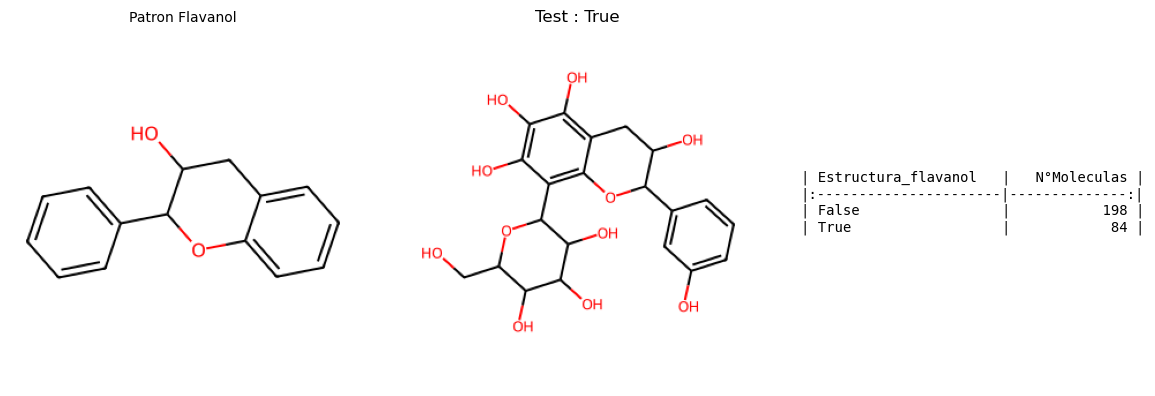

In [37]:
def verificar_flavanol(smiles_molecula):
    mol = Chem.MolFromSmiles(smiles_molecula)
    if mol:
        return mol.HasSubstructMatch(patron_flavanol)
    else:
        return False  
        
# Lista de moléculas
moleculas = [
    "O1C(C(O)C(O)C(O)C1CO)C2=C3OC(C(O)CC3=C(O)C(O)=C2O)C4=CC(O)=CC=C4",
    "C1C(OC2=CC=CC=C2C1=O)C3=CC=CC=C3",
    "C1=CC2=CC3=CC=CC=C3C=C2C=C1",
    "C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O"
]

# Patrón Flavanol
smiles_flavanol =("C1C(C(OC2=CC=CC=C21)C3=CC=CC=C3)O")
imagen_flavanol = plot_molecula(smiles_flavanol)
patron_flavanol = Chem.MolFromSmiles(smiles_flavanol)
# Seleccionar una molécula aleatoria
smiles_molecula_aleatoria = random.choice(moleculas)
imagen_molecula = plot_molecula(smiles_molecula_aleatoria)
es_flavanol = verificar_flavanol(smiles_molecula_aleatoria)       

# Mascara para indices "tipo_flavonoide" vacio
mascarafiltro = df.index.isin(indices_tipo_flavonoide_vacio)
# Aplicar la función a la mascara
df.loc[mascarafiltro, 'Estructura_flavanol'] = df.loc[mascarafiltro, 'SMILES'].apply(verificar_flavanol)
# Group by Estructura_flavanol
grupo_flavanol = df.groupby('Estructura_flavanol').size()
# Markdown
grupo_flavanol_md = grupo_flavanol.reset_index(name="N°Moleculas").to_markdown(index=False)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Ajusta el tamaño de la figura
# Subplot 1 = Patron Flavanol
ax1 = axs[0]
ax1.imshow(imagen_flavanol)  
ax1.set_title("Patron Flavanol", fontsize=10)
#Subplot 2 = Test +
ax2 = axs[1]
ax2.imshow(imagen_molecula)
ax2.set_title(f"Test : {es_flavanol}", fontsize=12)
#Subplot 3 = Markdown
ax3 = axs[2]
ax3.text(0.5, 0.5, grupo_flavanol_md, ha='center', va='center', fontsize=10, color='black', fontfamily='monospace')
ax1.axis('off')
ax2.axis('off')
ax3.axis('off')
#Mostrar Plot
plt.tight_layout()
plt.show()

In [38]:
# Filtrar las filas con índices en `indices_tipo_flavonoide_vacio` y donde 'Estructura_flavanol' sea True
df.loc[(mascarafiltro) & (df['Estructura_flavanol'] == True), 'Tipo_flavonoide'] = 'Flavanol'
# Filtrar las filas con índices en `indices_tipo_flavonoide_vacio` y donde 'Estructura_flavanol' sea False
df.loc[(mascarafiltro) & (df['Estructura_flavanol'] == False), 'Tipo_flavonoide'] = 'Otro'
#Array
array_tipos_flavonoide = np.array(df['Tipo_flavonoide'])
#Asignar valores
valores_flavanol = array_tipos_flavonoide == 'Flavanol'
valores_otro = array_tipos_flavonoide == 'Otro'
#Obtener índices
indices_flavanol = np.where(valores_flavanol)[0]
indices_otro = np.where(valores_otro)[0]

df[['ChEBI Name', 'SMILES', 'Tipo_flavonoide']].sample(n=10)


,ChEBI Name,SMILES,Tipo_flavonoide
483,Jaceidin 4'-glucuronide,O1[C@@H]([C@@H](O)[C@H](O)[C@@H](O)[C@@H]1OC2=...,Flavonol
376,2''-galloylhyperin,O1[C@@H]([C@H](O)[C@H](O)[C@@H](OC(=O)C2=CC(O)...,Flavonol
958,Tephrowatsin B,O1C=2C(CC=C(C)C)=C(OC)C=C(OC)C2C=C[C@H]1C3=CC=...,Otro
1166,"Laricitrin 3,7,5'-triglucoside",O1C([C@@H](O)C(O)C(O)[C@@H]1OC2=C(OC=3C(C2=O)=...,Flavonol
560,Agestricin D,O1C(CC(=O)C=2C1=CC(OC)=C(O)C2OC)C3=CC(OC)=C(O)...,Flavanona
703,Quercetin 3-methyl ether 7-alpha-L-arabinofura...,O1C([C@@H](O)[C@H](O)C(O)[C@@H]1OC=2C=C3OC(=C(...,Flavonol
373,"6,3',4'-Trimethoxyflavanone",O1C(CC(=O)C2=C1C=CC(OC)=C2)C3=CC(OC)=C(OC)C=C3,Flavanona
479,Isoswertiajaponin,O1[C@](C(O)[C@@H](O)[C@@H](O)C1CO)(C=2C=3OC(=C...,Flavona
493,5-Carboxypyranocyanidin 3-O-(6''-O-malonyl-bet...,O1[C@@H]([C@@H](O)C(O)C(O)[C@@H]1OC=2C3=C4C(OC...,Otro
450,Apigenin 7-(2''-acetyl-6''-methylglucuronide),O1C([C@@H](O)[C@H](O)C(OC(=O)C)[C@@H]1OC=2C=C3...,Flavona


### Test clasificacion Flavanol y Otros
###### (CTRL + ENTER para actualizar molecula)

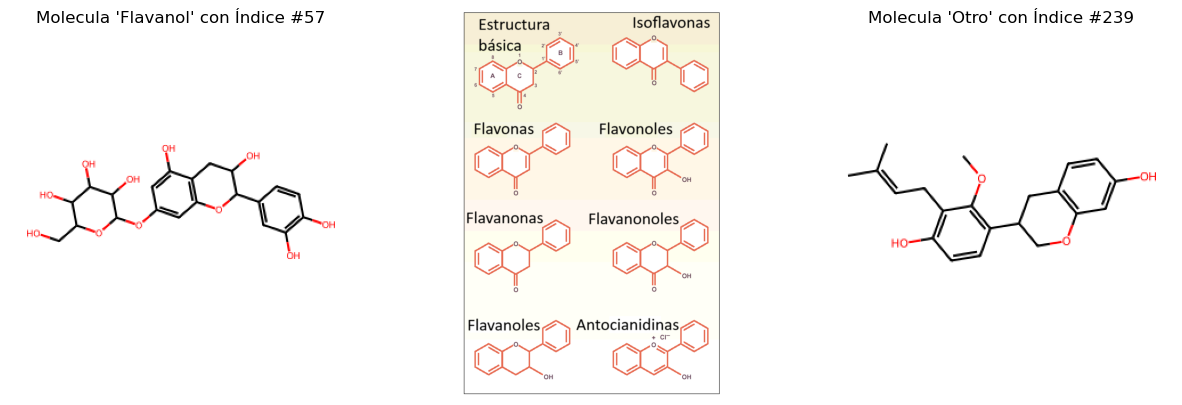

In [39]:
#Test para visualizar moleculas clasificadas

#Molecula Flavanol
df_flavanol = df[df['Tipo_flavonoide'] == 'Flavanol']
indice_molecula_flavanol = random.choice(df_flavanol.index) #Obtener índice random
# Obtener el SMILES de la molécula en el índice dado
smiles_molecula_flavanol = df.loc[indice_molecula_flavanol, 'SMILES']
plot_molecula(smiles_molecula_flavanol)
#Molecula "Otro"
df_otro = df[df['Tipo_flavonoide'] == 'Otro']
indice_molecula_otro = random.choice(df_otro.index) #Obtener índice random
# Obtener el SMILES de la molécula en el índice dado
smiles_molecula_otro = df.loc[indice_molecula_otro, 'SMILES']
plot_molecula(smiles_molecula_otro)

# Llena los valores NaN en la columna 'Estructura_flavanol' con False
df['Estructura_flavanol'] = df['Estructura_flavanol'].fillna(False)
df['Estructura_flavanol'] = df['Estructura_flavanol'].astype(bool)

#Plot
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # Ajusta el tamaño de la figura
# Eliminar los ejes de todas las imágenes
for ax in axs:
    ax.axis('off')
#Subplot 1 = "Flavanol"
axs[0].set_title(f"Molecula 'Flavanol' con Índice #{indice_molecula_flavanol}")  # Título para la imagen 1
imagen_molecula_flavanol = plot_molecula(smiles_molecula_flavanol)
axs[0].imshow(imagen_molecula_flavanol)
#Subplot 2 = "Estructuras flavonoides"
imagen = Image.open(ruta_imagen)
axs[1].imshow(imagen)
# Subplot 3 : "Otro"
axs[2].set_title(f"Molecula 'Otro' con Índice #{indice_molecula_otro}")  # Título para la imagen 3
imagen_molecula_otro = plot_molecula(smiles_molecula_otro)
axs[2].imshow(imagen_molecula_otro)
# Mostrar el gráfico
plt.show()

Ver moleculas sin clasificar

In [40]:
# Filtrar las filas donde 'Tipo_flavonoide' está vacío
indices_tipo_flavonoide_vacio = df[df['Tipo_flavonoide'] == ''].index

# Verificar los índices obtenidos
print(f"Existen {len(indices_tipo_flavonoide_vacio)} Moleculas sin clasificar")

Existen 0 Moleculas sin clasificar


# Asi quedó clasificada nuestra base de datos:

Text(0.5, 1.0, 'Distribución de Tipos de Flavonoides')

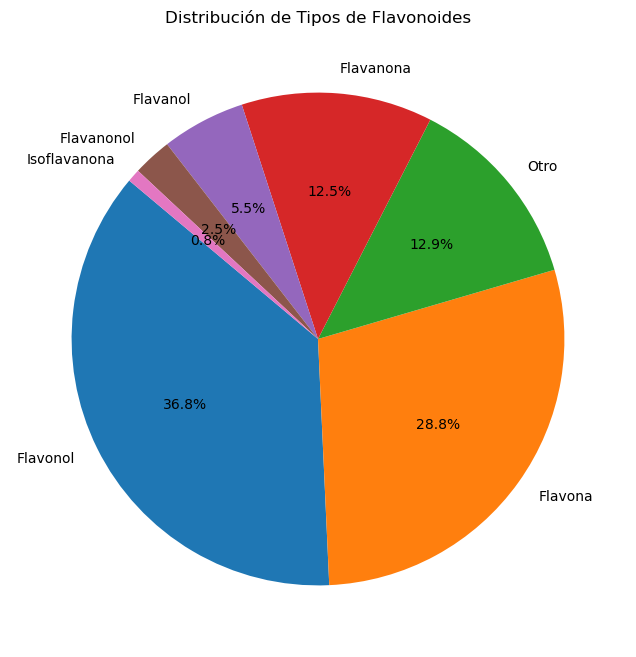

In [74]:
frequencias = df['Tipo_flavonoide'].value_counts()
# Plot
plt.figure(figsize=(8, 8))
plt.pie(frequencias, labels=frequencias.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Tipos de Flavonoides')

# Comprobar Errores
__________________________________________________________________________________________________________________________________________
Para verificar si nuestros Flavonoides fueron clasificados correctamente, comprobaremos si presentan mas de una de las estructuras de interes. En teoría solo deben compartir estructuras Flavonas-Flavonoles y Flavanonas-Flavanonoles

In [75]:
import itertools
condiciones = [
    'Estructura_isoflavanona',
    'Estructura_flavona',
    'Estructura_flavonol',
    'Estructura_flavanona',
    'Estructura_flavanonol',
    'Estructura_flavanol'
]

# Generar todas las combinaciones de dos estructuras
combinaciones_dos = list(itertools.combinations(condiciones, 2))
# Contar las moléculas que cumplen con cada combinación de dos condiciones
for combinacion in combinaciones_dos:
    condicion_combinada = df[list(combinacion)].all(axis=1)
    moléculas_cumplen = condicion_combinada.sum()
    print(f"Combinación {', '.join(combinacion)}: {moléculas_cumplen}")

Combinación Estructura_isoflavanona, Estructura_flavona: 0
Combinación Estructura_isoflavanona, Estructura_flavonol: 0
Combinación Estructura_isoflavanona, Estructura_flavanona: 0
Combinación Estructura_isoflavanona, Estructura_flavanonol: 0
Combinación Estructura_isoflavanona, Estructura_flavanol: 0
Combinación Estructura_flavona, Estructura_flavonol: 564
Combinación Estructura_flavona, Estructura_flavanona: 0
Combinación Estructura_flavona, Estructura_flavanonol: 0
Combinación Estructura_flavona, Estructura_flavanol: 0
Combinación Estructura_flavonol, Estructura_flavanona: 0
Combinación Estructura_flavonol, Estructura_flavanonol: 0
Combinación Estructura_flavonol, Estructura_flavanol: 0
Combinación Estructura_flavanona, Estructura_flavanonol: 39
Combinación Estructura_flavanona, Estructura_flavanol: 0
Combinación Estructura_flavanonol, Estructura_flavanol: 0


Tambien eliminamos las moleculas que no tienen valor en la columna "deltag"

In [76]:
# Crear una máscara booleana para identificar filas con valores nulos en 'deltag'
mask = df['deltag'].isnull()
# Aplicar la máscara al DataFrame para obtener las filas deseadas
filas_con_nulos = df[mask]

# Obtener las filas con valores nulos en 'deltag' y mostrar solo las columnas especificadas
columnas_a_mostrar = ['ChEBI ID', 'ChEBI Name', 'deltag']
print(df[mask][columnas_a_mostrar])

# Calcular la cantidad de moléculas sin valor 'deltag' y mostrar el resultado
cantidad_filas_con_nulos = len(df[mask])
print(f"La cantidad de moléculas sin 'deltag' es: {cantidad_filas_con_nulos}")

# Eliminar las filas con valores nulos en 'deltag' del DataFrame original
df = df.dropna(subset=['deltag'])
print(f"Se eliminaron : {cantidad_filas_con_nulos} moleculas")

      ChEBI ID                                         ChEBI Name  deltag
179     189019                             Cyanidin 3-arabinoside     NaN
198     176111                             Peonidin 3-arabinoside     NaN
347      72576                                            aurones     NaN
371     176112                            Petunidin 3-arabinoside     NaN
519      26377                                       pterocarpans     NaN
854     189427                                 Quercitrin Hydrate     NaN
1255    169736                        delphinidin-3-O-arabinoside     NaN
1259    184655  5,7,3'-Trihydroxy-4'-methoxyflavanone 7-(2,6-d...     NaN
1383     72577                                         coumestans     NaN
La cantidad de moléculas sin 'deltag' es: 9
Se eliminaron : 9 moleculas


#### Eliminamos columnas que ya no nos son de interes

In [77]:
df.columns

Index(['ChEBI ID', 'ChEBI Name', 'SMILES', 'deltag', 'SID', 'CID',
       'N°Carbonos', 'N°Oxigenos', 'N°S', 'N°N', 'N°Anillos', 'N°Aromaticos',
       'Estructura_isoflavona', 'Estructura_isoflavanona', 'Tipo_flavonoide',
       'Estructura_flavona', 'Estructura_flavonol', 'Estructura_flavanona',
       'Estructura_flavanonol', 'Estructura_flavanol'],
      dtype='object')

In [78]:
df = df.drop(columns=['Estructura_isoflavona', 'Estructura_isoflavanona', 'Estructura_flavona', 'Estructura_flavonol', 'Estructura_flavanona', 'Estructura_flavanonol','Estructura_flavanol'])

## Los Flavonoides ya están ordenados y clasificados:
### Ver molecula aleatoria de la base de datos:
###### (CTRL + ENTER para actualizar molecula)

Índice aleatorio: 1149
SMILES de la molécula:
ChEBI ID                                                      181838
ChEBI Name         2-[4-[1,3-dihydroxy-1-(4-hydroxy-3-methoxyphen...
SMILES             O(C(C(O)C1=CC(OC)=C(O)C=C1)CO)C2=C(OC)C=C(C=C2...
deltag                                                          -8.8
SID                                                         85380835
CID                                                         21159153
N°Carbonos                                                        27
N°Oxigenos                                                        11
N°S                                                                0
N°N                                                                0
N°Anillos                                                          4
N°Aromaticos                                                       4
Tipo_flavonoide                                              Flavona
Name: 1149, dtype: object


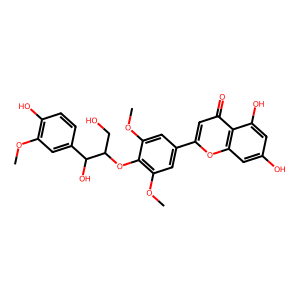

In [79]:
indice_aleatorio = df.sample().index[0]
# Obtener el SMILES correspondiente al índice aleatorio
smiles_molecula = df.loc[indice_aleatorio, 'SMILES']
# Mostrar el índice aleatorio y el SMILES de la molécula
print("Índice aleatorio:", indice_aleatorio)
print("SMILES de la molécula:")
print(df.loc[indice_aleatorio])
mostrar_molecula(smiles_molecula)  

# <u>Análisis</u>
#####  Normalizamos escala delta g :

In [80]:
from sklearn.preprocessing import MinMaxScaler
# Inicializa el MinMaxScaler
scaler = MinMaxScaler()
# Aplica el scaler a la columna 'deltag'
df['deltag_scaled'] = scaler.fit_transform(df['deltag'].values.reshape(-1, 1))
print(df[['ChEBI ID', 'deltag', 'deltag_scaled']].sample(n=10))

      ChEBI ID  deltag  deltag_scaled
1267    191556   -10.3       0.440678
1429    192235    -9.8       0.525424
1527    168975   -11.0       0.322034
568     169899    -9.5       0.576271
1344    192063   -10.8       0.355932
85      175238    -8.7       0.711864
242     184997    -8.6       0.728814
807     172612    -8.6       0.728814
509     107649    -8.3       0.779661
1207    140117    -8.9       0.677966


## Boxplot 
Afinidad vs Tipo de flavonoide 

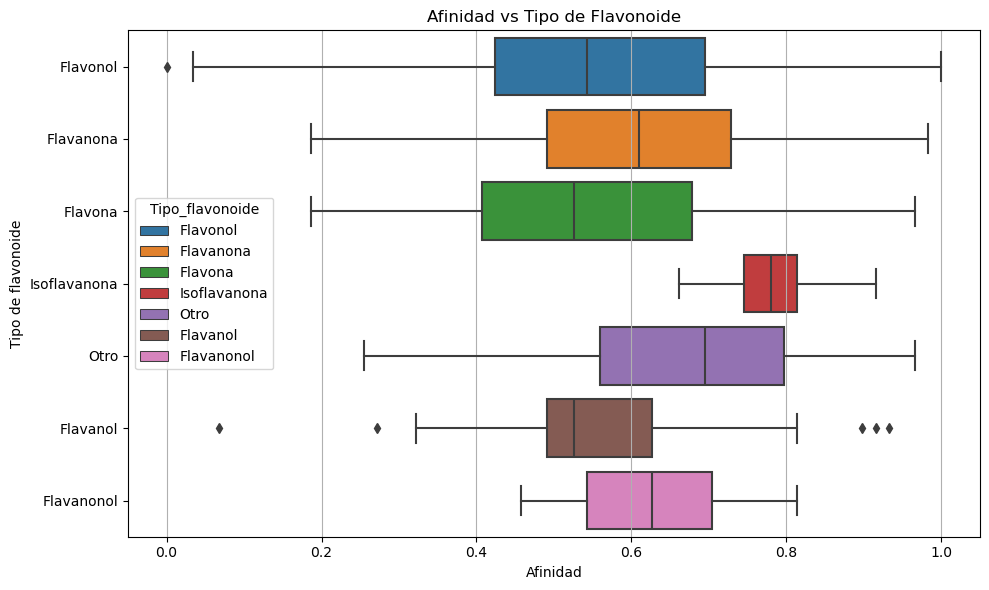

In [81]:
custom_palette = sns.color_palette("Set2", n_colors=7)  # Establecer n_colors al número correcto de categorías
plt.figure(figsize=(10, 6))
sns.boxplot(x='deltag_scaled', y='Tipo_flavonoide', data=df, hue='Tipo_flavonoide', orient='h', dodge=False)
# Plot
plt.xlabel('Afinidad')
plt.ylabel('Tipo de flavonoide')
plt.title('Afinidad vs Tipo de Flavonoide')
plt.grid(axis='x')  # Cambiar a grid en eje x
plt.tight_layout()

## Pruebas de normalidad :
### Histograma de frecuencia

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

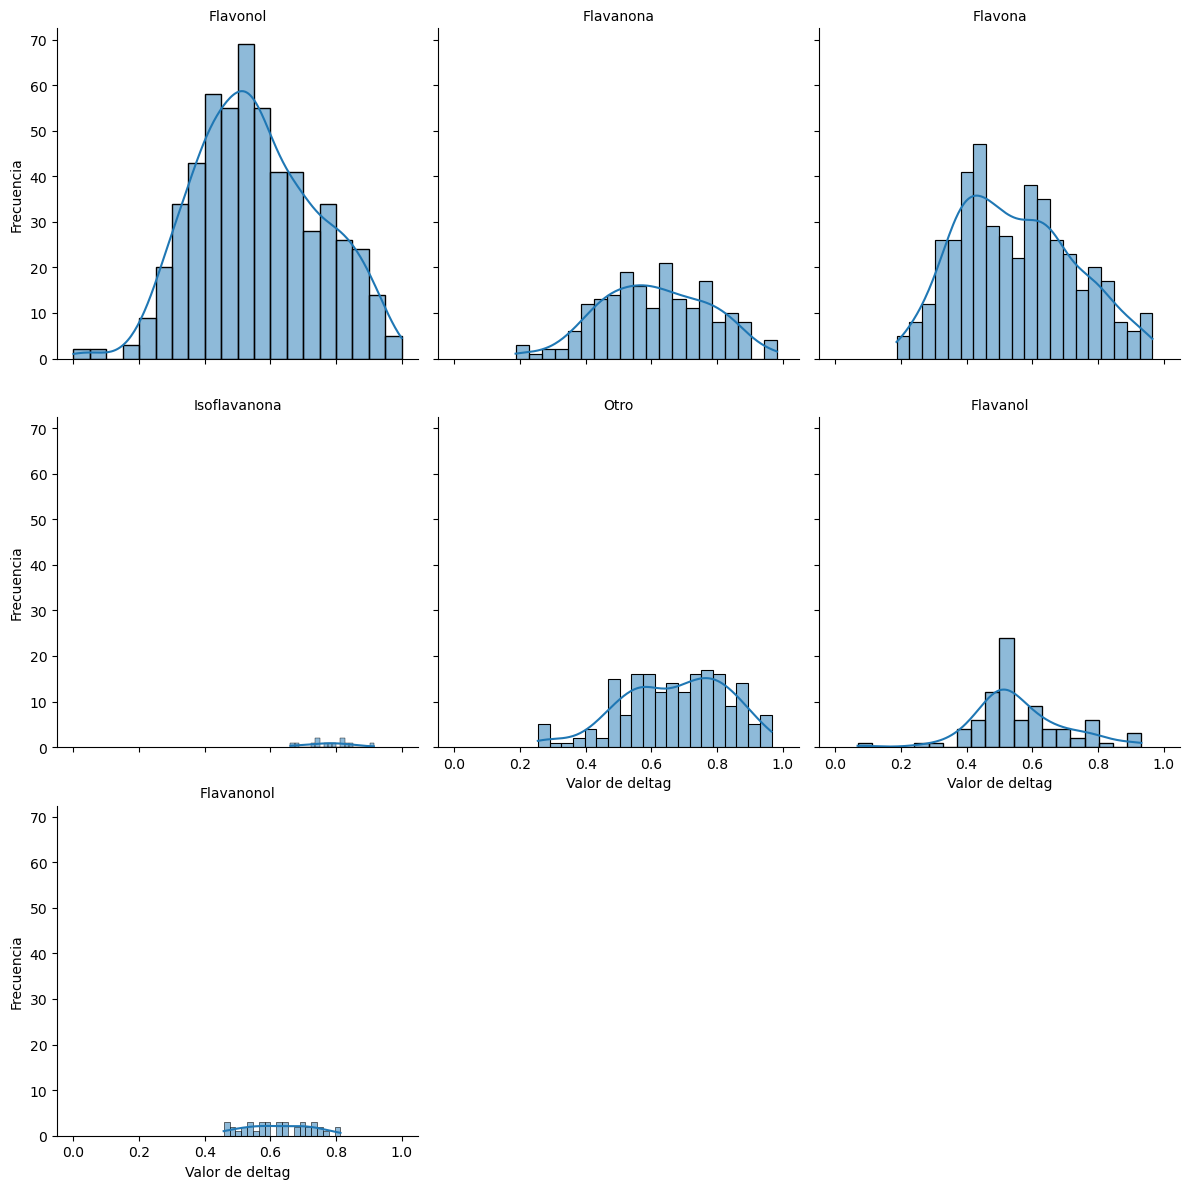

In [82]:
g = sns.FacetGrid(df, col='Tipo_flavonoide', col_wrap=3, height=4)
g.map_dataframe(sns.histplot, x='deltag_scaled', kde=True, bins=20)
# Agregar títulos y etiquetas a cada gráfico
g.set_axis_labels('Valor de deltag', 'Frecuencia')
g.set_titles('{col_name}')
g.set_xlabels('Valor de deltag')

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


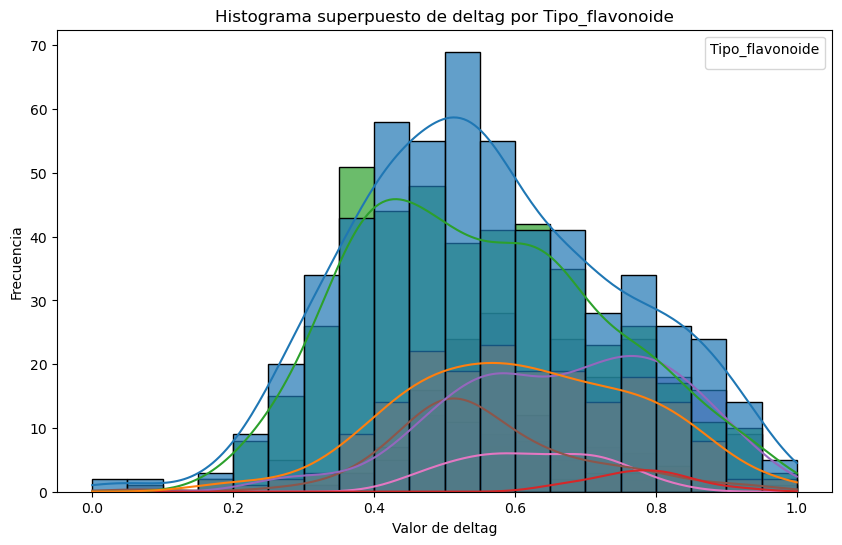

In [83]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='deltag_scaled', hue='Tipo_flavonoide', kde=True, bins=20, alpha=0.7)
plt.title('Histograma superpuesto de deltag por Tipo_flavonoide')
plt.xlabel('Valor de deltag')
plt.ylabel('Frecuencia')
plt.legend(title='Tipo_flavonoide')

### QQ Plot 

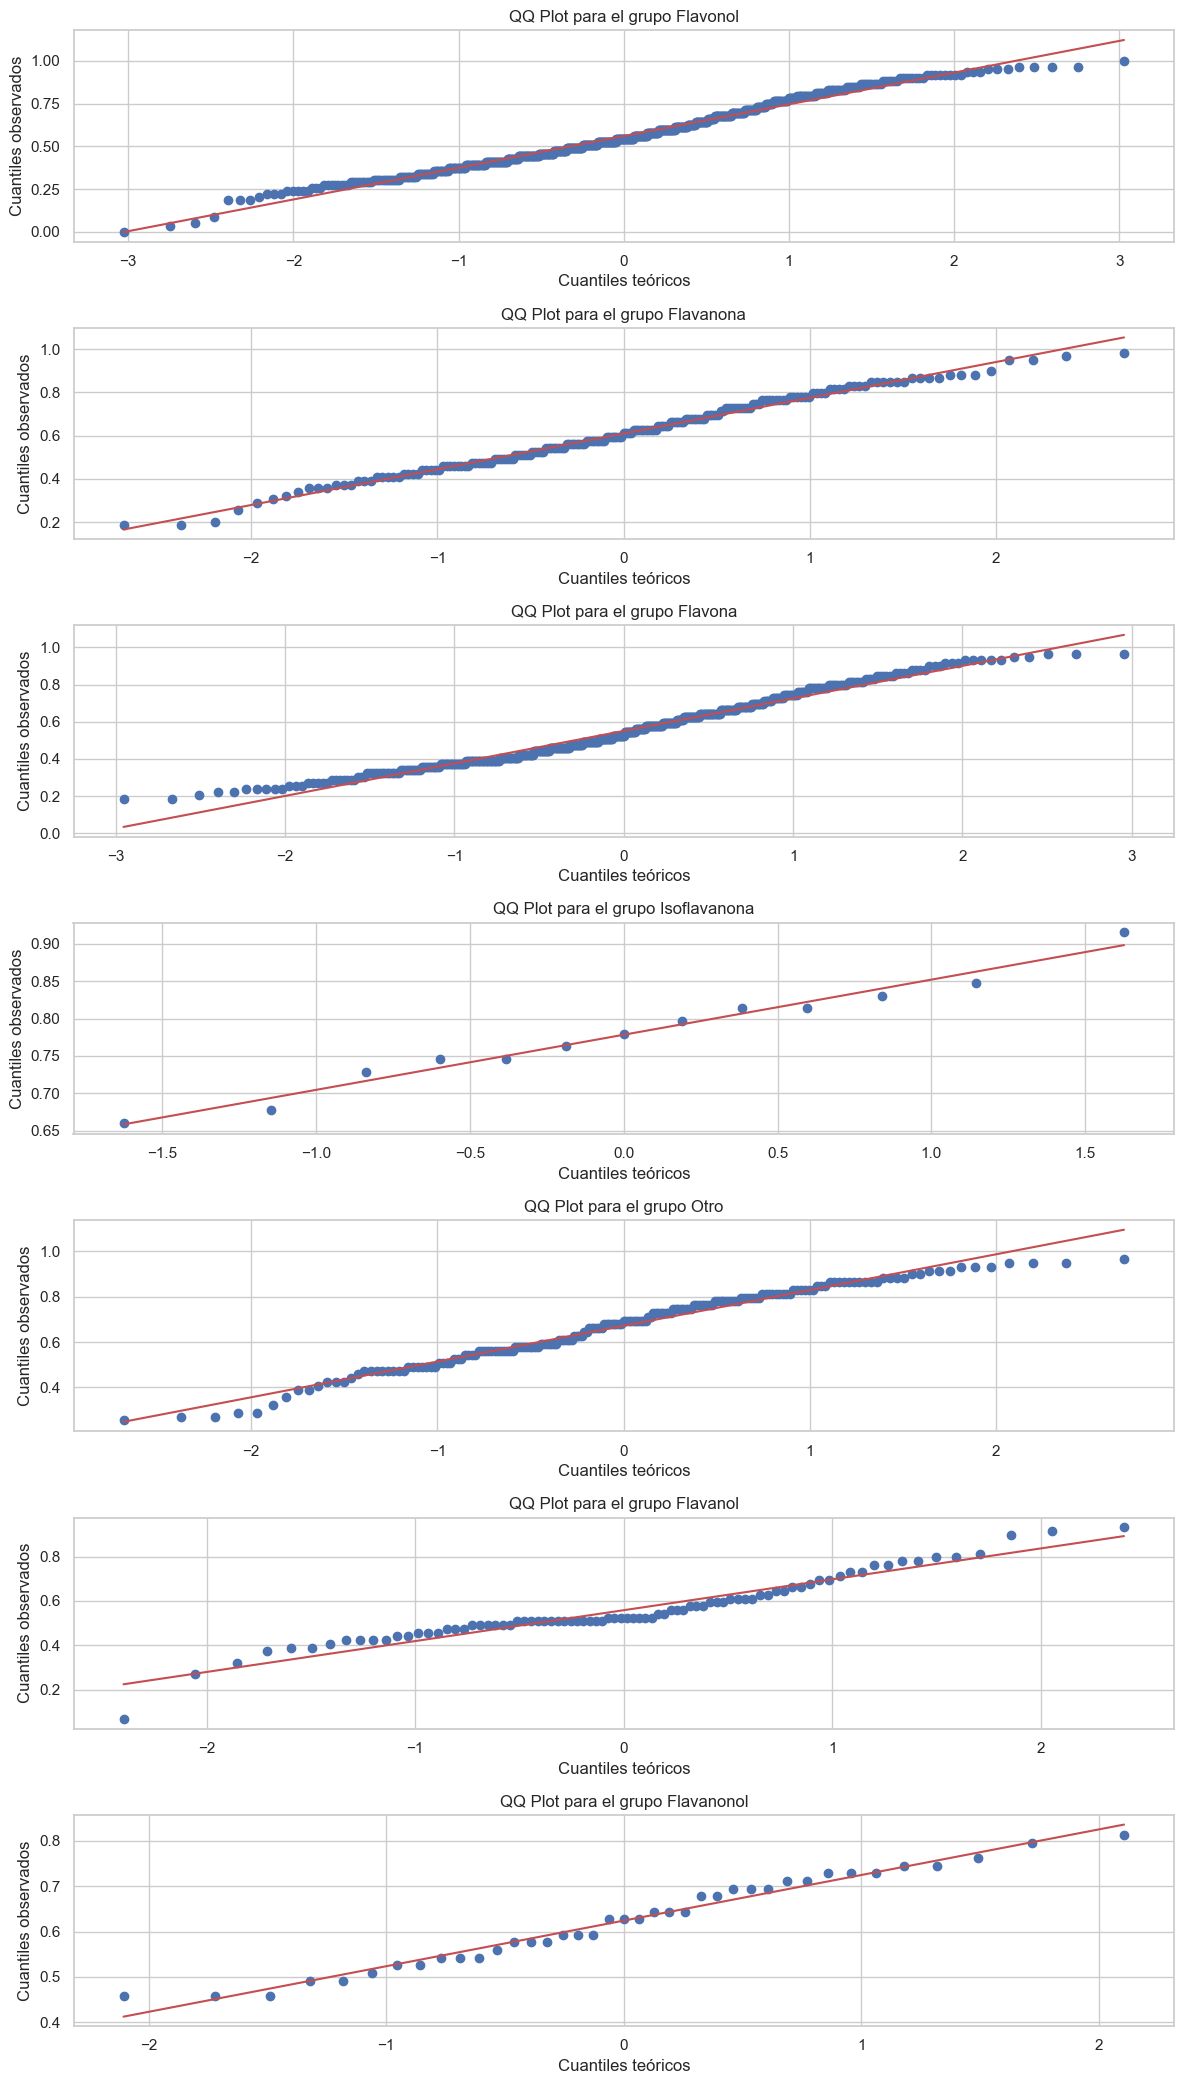

In [84]:
from scipy import stats
grupos_flavonoides = df['Tipo_flavonoide'].unique()

# Configurar el estilo y tamaño de las figuras
sns.set(style="whitegrid")
num_subplots = len(grupos_flavonoides)  # Número de subplots a crear
plt.figure(figsize=(12, 3 * num_subplots))  # Ajustar la altura según el número de subplots

# Iterar sobre cada grupo y generar un QQ Plot para cada uno
for i, grupo in enumerate(grupos_flavonoides, 1):
    # Filtrar los datos para el grupo actual
    datos_grupo = df[df['Tipo_flavonoide'] == grupo]['deltag_scaled']
    # Crear un subplot para cada QQ Plot
    plt.subplot(num_subplots, 1, i)
    # Generar el QQ Plot para el grupo actual
    stats.probplot(datos_grupo, dist="norm", plot=plt)
    plt.title(f'QQ Plot para el grupo {grupo}')
    plt.xlabel('Cuantiles teóricos')
    plt.ylabel('Cuantiles observados')   
plt.tight_layout()
plt.show()

#### Los grupos parecen tener una distribución normal

## Pruebas de Homocedasticidad : 

# Levenne
## Prueba apropiada para distribuciones no normales

In [85]:
from scipy.stats import levene
grouped_data = df.groupby('Tipo_flavonoide')['deltag_scaled']
# Crea una lista para almacenar los datos de cada grupo
data_groups = [group.values for name, group in grouped_data]
# Aplica el test de Levene a los datos
statistic, p_value = levene(*data_groups)
# Imprime los resultados del test
print("Estadístico de Levene:", statistic)
print("Valor p:", p_value)
# Comprueba la significancia del test
alpha = 0.05
if p_value > alpha:
    print("No se rechaza la hipótesis nula. Las varianzas son homogéneas.")
else:
    print("Se rechaza la hipótesis nula. Las varianzas no son homogéneas.")

Estadístico de Levene: 7.515815399875181
Valor p: 5.8952786126851915e-08
Se rechaza la hipótesis nula. Las varianzas no son homogéneas.


# Barlette
## Prueba apropiada para distribuciones normales


In [86]:
from scipy.stats import bartlett

grouped_data = [group['deltag_scaled'].dropna() for name, group in df.groupby('Tipo_flavonoide')]
bartlett_result = bartlett(*grouped_data)

# Mostrar el resultado del test de Bartlett
print("Estadístico de Bartlett:", bartlett_result.statistic)
print("Valor p de Bartlett:", bartlett_result.pvalue)

# Interpretar el resultado
if bartlett_result.pvalue > 0.05:
    print("No se rechaza la hipótesis nula. Las varianzas son homogéneas.")
else:
    print("Se rechaza la hipótesis nula. Las varianzas no son homogéneas.")

Estadístico de Bartlett: 44.90937138347169
Valor p de Bartlett: 4.8783379683224054e-08
Se rechaza la hipótesis nula. Las varianzas no son homogéneas.


## ANOVA de Welch
El ANOVA de Welch es una técnica estadística utilizada para comparar las medias de tres o más grupos 
cuando se asume que las varianzas entre los grupos son diferentes. A diferencia del ANOVA tradicional, 
que asume homocedasticidad (igualdad de varianzas), el ANOVA de Welch es robusto frente a violaciones de esta 
suposición. Esto lo hace especialmente útil cuando se trabaja con datos que tienen varianzas heterogéneas.

La siguiente tabla muestra los resultados del ANOVA de Welch realizado para comparar la variable 
dependiente 'deltag_scaled' entre los diferentes grupos definidos por 'Tipo_flavonoide'. 

Columnas de la tabla:
- Fuente: La fuente de variación (en este caso, el tipo de Flavonoide).
- Grados de Libertad 1: Los grados de libertad asociados con la variación entre grupos.
- Grados de Libertad 2: Los grados de libertad asociados con la variación dentro de los grupos.
- Estadístico F: La estadística F calculada.
- Valor p: El valor p asociado con la estadística F. Un valor p menor que 0.05 indica que hay diferencias significativas entre las medias de los grupos.
- Tamaño del efecto: Una medida del tamaño del efecto (por ejemplo, el epsilon cuadrado).

In [87]:
import pingouin as pg
from tabulate import tabulate

# Realizar el ANOVA de Welch
anova_result = pg.welch_anova(dv='deltag_scaled', between='Tipo_flavonoide', data=df)

# Renombrar las columnas basándonos en el resultado de la inspección
anova_result.columns = [
    "Fuente",             # Originalmente 'Source'
    "Grados de Libertad 1",  # Originalmente 'ddof1'
    "Grados de Libertad 2",  # Originalmente 'ddof2'
    "Estadístico F",      # Originalmente 'F'
    "Valor p",            # Originalmente 'p-unc'
    "Tamaño del efecto"   # Originalmente 'np2'
]

# Redondear los resultados a 4 decimales para mayor claridad
anova_result_rounded = anova_result.round(4)

# Mostrar la tabla de resultados con formato profesional
print("Resultados del ANOVA de Welch:")
print(tabulate(anova_result_rounded, headers='keys', tablefmt='grid'))

ModuleNotFoundError: No module named 'pingouin'

# Prueba de Games-Howell
La prueba de Games-Howell es una prueba post hoc utilizada para realizar comparaciones múltiples entre las medias de los grupos
cuando se ha detectado heterocedasticidad (diferencias en las varianzas) y se han encontrado diferencias significativas mediante un
ANOVA de Welch. Esta prueba no asume homocedasticidad y es robusta frente a diferencias en el tamaño de las muestras.

La siguiente tabla muestra los resultados de la prueba de Games-Howell realizada para comparar las medias de la variable
dependiente 'deltag_scaled' entre los diferentes grupos definidos por 'Tipo_flavonoide'.

Columnas de la tabla:
- A: Primer grupo en la comparación.
- B: Segundo grupo en la comparación.
- mean(A): Media de la variable dependiente para el primer grupo.
- mean(B): Media de la variable dependiente para el segundo grupo.
- diff: Diferencia de medias entre los grupos.
- se: Error estándar de la diferencia de medias.
- T: Estadístico t calculado para la diferencia de medias.
- p-tukey: Valor p ajustado de Tukey para la diferencia de medias. Un valor p menor que 0.05 indica que hay una diferencia significativa entre los dos grupos.
- hedges: Tamaño del efecto Hedges' g.

In [ ]:
# Realizar la prueba post hoc de Games-Howell
posthoc = pg.pairwise_gameshowell(dv='deltag_scaled', between='Tipo_flavonoide', data=df)
# Mostrar los resultados de la prueba de Games-Howell con formato profesional
print("Resultados de la prueba post hoc de Games-Howell:")
print(tabulate(posthoc, headers='keys', tablefmt='grid'))

_______________________________________________________________________________________________________________________________
...

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='N°Carbonos', y='deltag_scaled', data=df, color='black')
# Plot
plt.xlabel('N° de Carbonos')
plt.ylabel('Afinidad')
plt.title('N° de Carbonos vs Afinidad')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='N°Oxigenos', y='deltag_scaled', data=df, color='skyblue')
# Plot
plt.xlabel('N° de Oxigenos')
plt.ylabel('Afinidad')
plt.title('N°Oxigenos vs Afinidad')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')


In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='N°Anillos', y='deltag_scaled', data=df, color='yellow')
# Plot
plt.xlabel('N° de anillos ')
plt.ylabel('Afinidad')
plt.title('Afinidad vs N° de Anillos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='N°Aromaticos', y='deltag_scaled', data=df, color="lightgreen")
# Plot
plt.xlabel('N° de anillos aromáticos')
plt.ylabel('Afinidad')
plt.title('Distribución de delta_g por Anillos aromáticos')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()